### Raw data load

In [1]:
%cd
import dgl
import torch as th
import pandas as pd

/data/home/ksh0511


In [2]:
def extract_number(column_name):
    return ''.join(filter(str.isdigit, column_name))
def load_omics_data(file_path):
    omics_data = pd.read_csv(file_path, sep='\t')
    omics_data.set_index('Unnamed: 0', inplace=True)
    # 결과 출력
    print(omics_data.head())
    for i in(omics_data.columns[1:]):
        try:
            i = int(i)
        except ValueError:
            print(i)
    
    return omics_data

In [3]:
cnv_path = '.../cnv_refactored.tsv'
meth_path = '.../methylation_refactored.tsv'
mut_path = '.../mutation_refactored.tsv'
exp_path = '.../expression_refactored.tsv'


In [4]:
cnv_data = load_omics_data(cnv_path)
meth_data = load_omics_data(meth_path)
mut_data = load_omics_data(mut_path)
exp_data = load_omics_data(exp_path)

              148398     26155     84069     84808     57801      9636  \
Unnamed: 0                                                               
ACH-000238  1.025225  1.025225  1.025225  1.025225  1.025225  1.025225   
ACH-000818  0.543035  0.543035  0.543035  0.543035  0.543035  0.543035   
ACH-000422  1.217339  1.217339  1.217339  1.217339  1.217339  1.217339   
ACH-000652  1.057655  1.057655  1.057655  1.057655  1.057655  1.057655   
ACH-000985  0.920385  0.920385  0.920385  0.920385  0.920385  0.920385   

              375790     54991    254173      8784  ...      3581    6736  \
Unnamed: 0                                          ...                     
ACH-000238  1.025225  1.025225  1.025225  1.025225  ...  0.053653     NaN   
ACH-000818  0.543035  0.543035  0.543035  0.543035  ...  0.841042     NaN   
ACH-000422  1.217339  1.217339  1.217339  1.217339  ...  0.660333  0.3207   
ACH-000652  1.057655  1.057655  1.057655  1.057655  ...  1.837768     NaN   
ACH-000985  0.92038

            101060200      5734     84285     64240      7852       826  \
Unnamed: 0                                                                
ACH-000058   0.984137  2.019524  4.420996  0.008593  2.878444  8.826616   
ACH-000867   0.752579  4.105001  4.977835 -0.004166  0.067020  8.814895   
ACH-000437   1.589078  3.362272  4.755702 -0.004166  2.209505  8.771923   
ACH-000544   0.530802  0.609288  3.859448 -0.004166  0.104263  7.144498   
ACH-000278   0.493279  1.400472  6.061079 -0.004166  2.367047  9.137787   

               27067      2254      7111    388610  ...    203076      1019  \
Unnamed: 0                                          ...                       
ACH-000058  5.407303 -0.029023  1.400411  6.347738  ... -0.005354  7.441620   
ACH-000867  3.069003  2.782023  0.232672  1.809070  ... -0.005354  6.384088   
ACH-000437  3.884004 -0.029023  0.019448  3.981100  ... -0.005354  7.585373   
ACH-000544  3.482456  0.022812  0.978874  2.231804  ... -0.005354  6.186923   


### mutation 초기화

In [5]:
mut_genes = set(mut_data.columns)
meth_genes = set(meth_data.columns)
exp_genes = set(exp_data.columns)
cnv_genes = set(cnv_data.columns)

# 공통 유전자 찾기 : meth & exp & cnv (mut는 제외)
common_genes_set =meth_genes&exp_genes&cnv_genes
common_genes = list(set(meth_data.columns) & set(exp_data.columns) & set(cnv_data.columns))
# 각 데이터프레임에서 공통 유전자에 포함되지 않은 유전자 찾기
mut_unique_genes = mut_genes - common_genes_set
meth_unique_genes = meth_genes - common_genes_set
exp_unique_genes = exp_genes - common_genes_set
cnv_unique_genes = cnv_genes - common_genes_set

print("common_genes",len(common_genes))
print("Unique genes in mut_data:", len(mut_unique_genes),mut_unique_genes)
print("Unique genes in meth_data:", len(meth_unique_genes),meth_unique_genes)
print("Unique genes in exp_data:", len(exp_unique_genes),exp_unique_genes)
print("Unique genes in cnv_data:", len(cnv_unique_genes),cnv_unique_genes)

common_cells = list(set(cnv_data.index) & set(meth_data.index) & set(exp_data.index))
print("common_cells",len(common_cells))


common_genes 14356
Unique genes in mut_data: 0 set()
Unique genes in meth_data: 0 set()
Unique genes in exp_data: 0 set()
Unique genes in cnv_data: 0 set()
common_cells 632


In [6]:
# mutation에 존재하지 않는 gene 컬럼 추가 및 초기화
def add_missing_genes(data, common_genes):
    missing_genes = common_genes - set(data.columns)
    for gene in missing_genes:
        data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
    return data

# 존재하지 않는 cell line 행 초기화
def add_missing_cells(data, common_cells, vector_size=26):
    missing_cells = set(common_cells) - set(data.index)
    for cell in missing_cells:
        data.loc[cell] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data.columns)
    return data

In [7]:
mut_data = add_missing_genes(mut_data, common_genes_set)
mut_data = add_missing_cells(mut_data, common_cells)

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gene] = ['0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'] * len(data)
/tmp/ipykernel_354525/1487665932.py:5: PerformanceWarning: DataFrame is highly fragmented.  This i

In [8]:
# 추가된 mutation 출력
mut_data

,147694,8270,1583,178,5525,23258,8760,22899,629,126669,...,644844,118442,100529063,56882,84285,158293,389383,645121,541466,10209
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ACH-000150,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
ACH-000669,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
ACH-000005,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
ACH-000973,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [9]:
cnv_data_filtered = cnv_data.loc[common_cells, common_genes]
meth_data_filtered = meth_data.loc[common_cells, common_genes]
exp_data_filtered = exp_data.loc[common_cells, common_genes]
mut_data_filtered = mut_data.loc[common_cells, common_genes]

### 데이터 통합

In [10]:
from tqdm import tqdm    
# 빈 데이터프레임 생성 (유전자별 4차원 벡터를 저장할 데이터프레임)
combined_df = pd.DataFrame(index=common_cells, columns=common_genes)

for cell in tqdm(common_cells, desc="Processing cells"):
    for gene in common_genes:
        combined_vector = [
            cnv_data_filtered.at[cell, gene],
            meth_data_filtered.at[cell, gene],
            exp_data_filtered.at[cell, gene]
        ]
        for i, value in enumerate(combined_vector):
            if pd.isna(value):
                if i == 0:
                    print(f"NaN found at cell: {cell}, gene: {gene}, file: CNV")
                elif i == 1:
                    print(f"NaN found at cell: {cell}, gene: {gene}, file: Methylation")
                elif i == 2:
                    print(f"NaN found at cell: {cell}, gene: {gene}, file: Expression")
                #elif i == 3:
                #    print(f"NaN found at cell: {cell}, gene: {gene}, file: Mutation")
                combined_vector[i] = 1.0
        combined_vector_rounded = [round(float(x), 7) for x in combined_vector]
        combined_df.at[cell, gene] = ','.join(map(str, combined_vector_rounded))

Processing cells:   0%|                                 | 0/632 [00:00<?, ?it/s]

NaN found at cell: ACH-000264, gene: 90665, file: CNV
NaN found at cell: ACH-000264, gene: 140032, file: CNV
NaN found at cell: ACH-000264, gene: 8653, file: CNV
NaN found at cell: ACH-000264, gene: 7544, file: CNV
NaN found at cell: ACH-000264, gene: 8284, file: CNV
NaN found at cell: ACH-000264, gene: 22829, file: CNV
NaN found at cell: ACH-000264, gene: 6192, file: CNV
NaN found at cell: ACH-000264, gene: 9087, file: CNV


Processing cells:   0%|                         | 1/632 [00:02<26:32,  2.52s/it]

NaN found at cell: ACH-000264, gene: 6736, file: CNV


Processing cells:   1%|▎                        | 7/632 [00:05<06:54,  1.51it/s]

NaN found at cell: ACH-000783, gene: 90665, file: CNV
NaN found at cell: ACH-000783, gene: 140032, file: CNV
NaN found at cell: ACH-000783, gene: 8653, file: CNV
NaN found at cell: ACH-000783, gene: 7544, file: CNV
NaN found at cell: ACH-000783, gene: 8284, file: CNV
NaN found at cell: ACH-000783, gene: 22829, file: CNV
NaN found at cell: ACH-000783, gene: 6192, file: CNV
NaN found at cell: ACH-000783, gene: 9087, file: CNV


Processing cells:   1%|▎                        | 8/632 [00:06<06:44,  1.54it/s]

NaN found at cell: ACH-000783, gene: 6736, file: CNV


Processing cells:   3%|▋                       | 19/632 [00:12<06:06,  1.67it/s]

NaN found at cell: ACH-000784, gene: 90665, file: CNV
NaN found at cell: ACH-000784, gene: 140032, file: CNV
NaN found at cell: ACH-000784, gene: 8653, file: CNV
NaN found at cell: ACH-000784, gene: 7544, file: CNV
NaN found at cell: ACH-000784, gene: 8284, file: CNV
NaN found at cell: ACH-000784, gene: 22829, file: CNV
NaN found at cell: ACH-000784, gene: 6192, file: CNV
NaN found at cell: ACH-000784, gene: 9087, file: CNV


Processing cells:   3%|▊                       | 20/632 [00:13<06:08,  1.66it/s]

NaN found at cell: ACH-000784, gene: 6736, file: CNV
NaN found at cell: ACH-000298, gene: 90665, file: CNV
NaN found at cell: ACH-000298, gene: 140032, file: CNV
NaN found at cell: ACH-000298, gene: 8653, file: CNV
NaN found at cell: ACH-000298, gene: 7544, file: CNV
NaN found at cell: ACH-000298, gene: 8284, file: CNV
NaN found at cell: ACH-000298, gene: 22829, file: CNV
NaN found at cell: ACH-000298, gene: 6192, file: CNV
NaN found at cell: ACH-000298, gene: 9087, file: CNV
NaN found at cell: ACH-000298, gene: 6736, file: CNV


Processing cells:   4%|▉                       | 25/632 [00:16<06:01,  1.68it/s]

NaN found at cell: ACH-000777, gene: 90665, file: CNV
NaN found at cell: ACH-000777, gene: 140032, file: CNV
NaN found at cell: ACH-000777, gene: 8653, file: CNV
NaN found at cell: ACH-000777, gene: 7544, file: CNV
NaN found at cell: ACH-000777, gene: 8284, file: CNV
NaN found at cell: ACH-000777, gene: 22829, file: CNV
NaN found at cell: ACH-000777, gene: 6192, file: CNV
NaN found at cell: ACH-000777, gene: 9087, file: CNV


Processing cells:   4%|▉                       | 26/632 [00:16<06:08,  1.65it/s]

NaN found at cell: ACH-000777, gene: 6736, file: CNV


Processing cells:   6%|█▍                      | 37/632 [00:22<04:57,  2.00it/s]

NaN found at cell: ACH-000758, gene: 90665, file: CNV
NaN found at cell: ACH-000758, gene: 140032, file: CNV
NaN found at cell: ACH-000758, gene: 8653, file: CNV
NaN found at cell: ACH-000758, gene: 7544, file: CNV
NaN found at cell: ACH-000758, gene: 8284, file: CNV
NaN found at cell: ACH-000758, gene: 22829, file: CNV


Processing cells:   6%|█▍                      | 38/632 [00:23<04:43,  2.10it/s]

NaN found at cell: ACH-000758, gene: 6192, file: CNV
NaN found at cell: ACH-000758, gene: 9087, file: CNV
NaN found at cell: ACH-000758, gene: 6736, file: CNV


Processing cells:   6%|█▌                      | 41/632 [00:24<05:36,  1.76it/s]

NaN found at cell: ACH-000945, gene: 90665, file: CNV
NaN found at cell: ACH-000945, gene: 140032, file: CNV
NaN found at cell: ACH-000945, gene: 8653, file: CNV
NaN found at cell: ACH-000945, gene: 7544, file: CNV
NaN found at cell: ACH-000945, gene: 8284, file: CNV
NaN found at cell: ACH-000945, gene: 22829, file: CNV
NaN found at cell: ACH-000945, gene: 6192, file: CNV
NaN found at cell: ACH-000945, gene: 9087, file: CNV


Processing cells:   7%|█▌                      | 42/632 [00:25<05:46,  1.70it/s]

NaN found at cell: ACH-000945, gene: 6736, file: CNV


Processing cells:   8%|█▉                      | 51/632 [00:31<06:00,  1.61it/s]

NaN found at cell: ACH-000927, gene: 90665, file: CNV
NaN found at cell: ACH-000927, gene: 140032, file: CNV
NaN found at cell: ACH-000927, gene: 8653, file: CNV
NaN found at cell: ACH-000927, gene: 7544, file: CNV
NaN found at cell: ACH-000927, gene: 8284, file: CNV
NaN found at cell: ACH-000927, gene: 22829, file: CNV
NaN found at cell: ACH-000927, gene: 6192, file: CNV
NaN found at cell: ACH-000927, gene: 9087, file: CNV


Processing cells:   8%|█▉                      | 52/632 [00:31<05:58,  1.62it/s]

NaN found at cell: ACH-000927, gene: 6736, file: CNV


Processing cells:   9%|██▏                     | 56/632 [00:33<05:03,  1.90it/s]

NaN found at cell: ACH-000511, gene: 90665, file: CNV
NaN found at cell: ACH-000511, gene: 140032, file: CNV
NaN found at cell: ACH-000511, gene: 8653, file: CNV
NaN found at cell: ACH-000511, gene: 7544, file: CNV
NaN found at cell: ACH-000511, gene: 8284, file: CNV
NaN found at cell: ACH-000511, gene: 22829, file: CNV


Processing cells:   9%|██▏                     | 57/632 [00:34<04:46,  2.01it/s]

NaN found at cell: ACH-000511, gene: 6192, file: CNV
NaN found at cell: ACH-000511, gene: 9087, file: CNV
NaN found at cell: ACH-000511, gene: 6736, file: CNV
NaN found at cell: ACH-000352, gene: 90665, file: CNV
NaN found at cell: ACH-000352, gene: 140032, file: CNV
NaN found at cell: ACH-000352, gene: 8653, file: CNV
NaN found at cell: ACH-000352, gene: 7544, file: CNV
NaN found at cell: ACH-000352, gene: 8284, file: CNV
NaN found at cell: ACH-000352, gene: 22829, file: CNV
NaN found at cell: ACH-000352, gene: 6192, file: CNV
NaN found at cell: ACH-000352, gene: 9087, file: CNV
NaN found at cell: ACH-000352, gene: 6736, file: CNV


Processing cells:   9%|██▎                     | 60/632 [00:36<05:31,  1.73it/s]

NaN found at cell: ACH-000679, gene: 90665, file: CNV
NaN found at cell: ACH-000679, gene: 140032, file: CNV
NaN found at cell: ACH-000679, gene: 8653, file: CNV
NaN found at cell: ACH-000679, gene: 7544, file: CNV
NaN found at cell: ACH-000679, gene: 8284, file: CNV
NaN found at cell: ACH-000679, gene: 22829, file: CNV
NaN found at cell: ACH-000679, gene: 6192, file: CNV
NaN found at cell: ACH-000679, gene: 9087, file: CNV


Processing cells:  10%|██▎                     | 61/632 [00:36<05:37,  1.69it/s]

NaN found at cell: ACH-000679, gene: 6736, file: CNV


Processing cells:  11%|██▌                     | 68/632 [00:39<04:10,  2.25it/s]

NaN found at cell: ACH-000408, gene: 90665, file: CNV
NaN found at cell: ACH-000408, gene: 140032, file: CNV
NaN found at cell: ACH-000408, gene: 8653, file: CNV
NaN found at cell: ACH-000408, gene: 7544, file: CNV
NaN found at cell: ACH-000408, gene: 8284, file: CNV
NaN found at cell: ACH-000408, gene: 22829, file: CNV


Processing cells:  11%|██▌                     | 69/632 [00:40<04:25,  2.12it/s]

NaN found at cell: ACH-000408, gene: 6192, file: CNV
NaN found at cell: ACH-000408, gene: 9087, file: CNV
NaN found at cell: ACH-000408, gene: 6736, file: CNV


Processing cells:  11%|██▋                     | 71/632 [00:41<05:07,  1.82it/s]

NaN found at cell: ACH-000670, gene: 90665, file: CNV
NaN found at cell: ACH-000670, gene: 140032, file: CNV
NaN found at cell: ACH-000670, gene: 8653, file: CNV
NaN found at cell: ACH-000670, gene: 7544, file: CNV
NaN found at cell: ACH-000670, gene: 8284, file: CNV
NaN found at cell: ACH-000670, gene: 22829, file: CNV
NaN found at cell: ACH-000670, gene: 6192, file: CNV
NaN found at cell: ACH-000670, gene: 9087, file: CNV


Processing cells:  11%|██▋                     | 72/632 [00:42<05:22,  1.74it/s]

NaN found at cell: ACH-000670, gene: 6736, file: CNV


Processing cells:  13%|███▏                    | 85/632 [00:48<03:58,  2.29it/s]

NaN found at cell: ACH-000759, gene: 90665, file: CNV
NaN found at cell: ACH-000759, gene: 140032, file: CNV
NaN found at cell: ACH-000759, gene: 8653, file: CNV
NaN found at cell: ACH-000759, gene: 7544, file: CNV
NaN found at cell: ACH-000759, gene: 8284, file: CNV
NaN found at cell: ACH-000759, gene: 22829, file: CNV


Processing cells:  14%|███▎                    | 86/632 [00:49<04:08,  2.20it/s]

NaN found at cell: ACH-000759, gene: 6192, file: CNV
NaN found at cell: ACH-000759, gene: 9087, file: CNV
NaN found at cell: ACH-000759, gene: 6736, file: CNV


Processing cells:  14%|███▍                    | 89/632 [00:51<05:07,  1.77it/s]

NaN found at cell: ACH-000019, gene: 90665, file: CNV
NaN found at cell: ACH-000019, gene: 140032, file: CNV
NaN found at cell: ACH-000019, gene: 8653, file: CNV
NaN found at cell: ACH-000019, gene: 7544, file: CNV
NaN found at cell: ACH-000019, gene: 8284, file: CNV
NaN found at cell: ACH-000019, gene: 22829, file: CNV
NaN found at cell: ACH-000019, gene: 6192, file: CNV
NaN found at cell: ACH-000019, gene: 9087, file: CNV


Processing cells:  14%|███▍                    | 90/632 [00:51<05:18,  1.70it/s]

NaN found at cell: ACH-000019, gene: 6736, file: CNV
NaN found at cell: ACH-000963, gene: 90665, file: CNV
NaN found at cell: ACH-000963, gene: 140032, file: CNV
NaN found at cell: ACH-000963, gene: 8653, file: CNV
NaN found at cell: ACH-000963, gene: 7544, file: CNV
NaN found at cell: ACH-000963, gene: 8284, file: CNV
NaN found at cell: ACH-000963, gene: 22829, file: CNV


Processing cells:  14%|███▍                    | 91/632 [00:52<05:24,  1.67it/s]

NaN found at cell: ACH-000963, gene: 6192, file: CNV
NaN found at cell: ACH-000963, gene: 9087, file: CNV
NaN found at cell: ACH-000963, gene: 6736, file: CNV


Processing cells:  15%|███▍                    | 92/632 [00:52<05:20,  1.68it/s]

NaN found at cell: ACH-000506, gene: 90665, file: CNV
NaN found at cell: ACH-000506, gene: 140032, file: CNV
NaN found at cell: ACH-000506, gene: 8653, file: CNV
NaN found at cell: ACH-000506, gene: 7544, file: CNV
NaN found at cell: ACH-000506, gene: 8284, file: CNV
NaN found at cell: ACH-000506, gene: 22829, file: CNV


Processing cells:  15%|███▌                    | 93/632 [00:53<05:04,  1.77it/s]

NaN found at cell: ACH-000506, gene: 6192, file: CNV
NaN found at cell: ACH-000506, gene: 9087, file: CNV
NaN found at cell: ACH-000506, gene: 6736, file: CNV


Processing cells:  15%|███▋                    | 96/632 [00:55<05:20,  1.67it/s]

NaN found at cell: ACH-000349, gene: 90665, file: CNV
NaN found at cell: ACH-000349, gene: 140032, file: CNV
NaN found at cell: ACH-000349, gene: 8653, file: CNV
NaN found at cell: ACH-000349, gene: 7544, file: CNV
NaN found at cell: ACH-000349, gene: 8284, file: CNV
NaN found at cell: ACH-000349, gene: 22829, file: CNV
NaN found at cell: ACH-000349, gene: 6192, file: CNV
NaN found at cell: ACH-000349, gene: 9087, file: CNV


Processing cells:  15%|███▋                    | 97/632 [00:55<05:23,  1.65it/s]

NaN found at cell: ACH-000349, gene: 6736, file: CNV


Processing cells:  16%|███▋                    | 98/632 [00:56<05:25,  1.64it/s]

NaN found at cell: ACH-000139, gene: 90665, file: CNV
NaN found at cell: ACH-000139, gene: 140032, file: CNV
NaN found at cell: ACH-000139, gene: 8653, file: CNV
NaN found at cell: ACH-000139, gene: 7544, file: CNV
NaN found at cell: ACH-000139, gene: 8284, file: CNV
NaN found at cell: ACH-000139, gene: 22829, file: CNV
NaN found at cell: ACH-000139, gene: 6192, file: CNV
NaN found at cell: ACH-000139, gene: 9087, file: CNV


Processing cells:  16%|███▊                    | 99/632 [00:57<05:26,  1.63it/s]

NaN found at cell: ACH-000139, gene: 6736, file: CNV


Processing cells:  16%|███▋                   | 103/632 [00:59<04:51,  1.81it/s]

NaN found at cell: ACH-000665, gene: 90665, file: CNV
NaN found at cell: ACH-000665, gene: 140032, file: CNV
NaN found at cell: ACH-000665, gene: 8653, file: CNV
NaN found at cell: ACH-000665, gene: 7544, file: CNV
NaN found at cell: ACH-000665, gene: 8284, file: CNV
NaN found at cell: ACH-000665, gene: 22829, file: CNV
NaN found at cell: ACH-000665, gene: 6192, file: CNV
NaN found at cell: ACH-000665, gene: 9087, file: CNV


Processing cells:  16%|███▊                   | 104/632 [01:00<05:01,  1.75it/s]

NaN found at cell: ACH-000665, gene: 6736, file: CNV
NaN found at cell: ACH-000639, gene: 90665, file: CNV
NaN found at cell: ACH-000639, gene: 140032, file: CNV
NaN found at cell: ACH-000639, gene: 8653, file: CNV
NaN found at cell: ACH-000639, gene: 7544, file: CNV
NaN found at cell: ACH-000639, gene: 8284, file: CNV
NaN found at cell: ACH-000639, gene: 22829, file: CNV


Processing cells:  17%|███▊                   | 105/632 [01:00<05:06,  1.72it/s]

NaN found at cell: ACH-000639, gene: 6192, file: CNV
NaN found at cell: ACH-000639, gene: 9087, file: CNV
NaN found at cell: ACH-000639, gene: 6736, file: CNV
NaN found at cell: ACH-000347, gene: 90665, file: CNV
NaN found at cell: ACH-000347, gene: 140032, file: CNV
NaN found at cell: ACH-000347, gene: 8653, file: CNV
NaN found at cell: ACH-000347, gene: 7544, file: CNV
NaN found at cell: ACH-000347, gene: 8284, file: CNV


Processing cells:  17%|███▊                   | 106/632 [01:01<04:56,  1.77it/s]

NaN found at cell: ACH-000347, gene: 22829, file: CNV
NaN found at cell: ACH-000347, gene: 6192, file: CNV
NaN found at cell: ACH-000347, gene: 9087, file: CNV
NaN found at cell: ACH-000347, gene: 6736, file: CNV
NaN found at cell: ACH-000693, gene: 90665, file: CNV
NaN found at cell: ACH-000693, gene: 140032, file: CNV
NaN found at cell: ACH-000693, gene: 8653, file: CNV
NaN found at cell: ACH-000693, gene: 7544, file: CNV
NaN found at cell: ACH-000693, gene: 8284, file: CNV
NaN found at cell: ACH-000693, gene: 22829, file: CNV


Processing cells:  17%|███▉                   | 107/632 [01:01<04:34,  1.92it/s]

NaN found at cell: ACH-000693, gene: 6192, file: CNV
NaN found at cell: ACH-000693, gene: 9087, file: CNV
NaN found at cell: ACH-000693, gene: 6736, file: CNV


Processing cells:  17%|████                   | 110/632 [01:02<03:56,  2.21it/s]

NaN found at cell: ACH-000515, gene: 90665, file: CNV
NaN found at cell: ACH-000515, gene: 140032, file: CNV
NaN found at cell: ACH-000515, gene: 8653, file: CNV
NaN found at cell: ACH-000515, gene: 7544, file: CNV
NaN found at cell: ACH-000515, gene: 8284, file: CNV
NaN found at cell: ACH-000515, gene: 22829, file: CNV


Processing cells:  18%|████                   | 111/632 [01:03<03:50,  2.26it/s]

NaN found at cell: ACH-000515, gene: 6192, file: CNV
NaN found at cell: ACH-000515, gene: 9087, file: CNV
NaN found at cell: ACH-000515, gene: 6736, file: CNV


Processing cells:  18%|████▏                  | 114/632 [01:04<03:39,  2.36it/s]

NaN found at cell: ACH-000270, gene: 90665, file: CNV
NaN found at cell: ACH-000270, gene: 140032, file: CNV
NaN found at cell: ACH-000270, gene: 8653, file: CNV
NaN found at cell: ACH-000270, gene: 7544, file: CNV
NaN found at cell: ACH-000270, gene: 8284, file: CNV
NaN found at cell: ACH-000270, gene: 22829, file: CNV


Processing cells:  18%|████▏                  | 115/632 [01:05<03:51,  2.23it/s]

NaN found at cell: ACH-000270, gene: 6192, file: CNV
NaN found at cell: ACH-000270, gene: 9087, file: CNV
NaN found at cell: ACH-000270, gene: 6736, file: CNV
NaN found at cell: ACH-000163, gene: 90665, file: CNV
NaN found at cell: ACH-000163, gene: 140032, file: CNV
NaN found at cell: ACH-000163, gene: 8653, file: CNV
NaN found at cell: ACH-000163, gene: 7544, file: CNV
NaN found at cell: ACH-000163, gene: 8284, file: CNV
NaN found at cell: ACH-000163, gene: 22829, file: CNV
NaN found at cell: ACH-000163, gene: 6192, file: CNV
NaN found at cell: ACH-000163, gene: 9087, file: CNV


Processing cells:  18%|████▏                  | 116/632 [01:05<04:14,  2.02it/s]

NaN found at cell: ACH-000163, gene: 6736, file: CNV


Processing cells:  19%|████▎                  | 118/632 [01:06<04:42,  1.82it/s]

NaN found at cell: ACH-000116, gene: 90665, file: CNV
NaN found at cell: ACH-000116, gene: 140032, file: CNV
NaN found at cell: ACH-000116, gene: 8653, file: CNV
NaN found at cell: ACH-000116, gene: 7544, file: CNV
NaN found at cell: ACH-000116, gene: 8284, file: CNV
NaN found at cell: ACH-000116, gene: 22829, file: CNV
NaN found at cell: ACH-000116, gene: 6192, file: CNV
NaN found at cell: ACH-000116, gene: 9087, file: CNV


Processing cells:  19%|████▎                  | 119/632 [01:07<04:53,  1.75it/s]

NaN found at cell: ACH-000116, gene: 6736, file: CNV


Processing cells:  19%|████▍                  | 121/632 [01:08<05:03,  1.68it/s]

NaN found at cell: ACH-000559, gene: 90665, file: CNV
NaN found at cell: ACH-000559, gene: 140032, file: CNV
NaN found at cell: ACH-000559, gene: 8653, file: CNV
NaN found at cell: ACH-000559, gene: 7544, file: CNV
NaN found at cell: ACH-000559, gene: 8284, file: CNV


Processing cells:  19%|████▍                  | 122/632 [01:09<04:51,  1.75it/s]

NaN found at cell: ACH-000559, gene: 22829, file: CNV
NaN found at cell: ACH-000559, gene: 6192, file: CNV
NaN found at cell: ACH-000559, gene: 9087, file: CNV
NaN found at cell: ACH-000559, gene: 6736, file: CNV


Processing cells:  20%|████▌                  | 126/632 [01:11<04:46,  1.77it/s]

NaN found at cell: ACH-000643, gene: 90665, file: CNV
NaN found at cell: ACH-000643, gene: 140032, file: CNV
NaN found at cell: ACH-000643, gene: 8653, file: CNV
NaN found at cell: ACH-000643, gene: 7544, file: CNV
NaN found at cell: ACH-000643, gene: 8284, file: CNV
NaN found at cell: ACH-000643, gene: 22829, file: CNV
NaN found at cell: ACH-000643, gene: 6192, file: CNV
NaN found at cell: ACH-000643, gene: 9087, file: CNV


Processing cells:  20%|████▌                  | 127/632 [01:11<04:52,  1.72it/s]

NaN found at cell: ACH-000643, gene: 6736, file: CNV


Processing cells:  21%|████▊                  | 131/632 [01:14<04:12,  1.99it/s]

NaN found at cell: ACH-000361, gene: 90665, file: CNV
NaN found at cell: ACH-000361, gene: 140032, file: CNV
NaN found at cell: ACH-000361, gene: 8653, file: CNV
NaN found at cell: ACH-000361, gene: 7544, file: CNV
NaN found at cell: ACH-000361, gene: 8284, file: CNV
NaN found at cell: ACH-000361, gene: 22829, file: CNV


Processing cells:  21%|████▊                  | 132/632 [01:14<03:58,  2.10it/s]

NaN found at cell: ACH-000361, gene: 6192, file: CNV
NaN found at cell: ACH-000361, gene: 9087, file: CNV
NaN found at cell: ACH-000361, gene: 6736, file: CNV


Processing cells:  22%|█████                  | 140/632 [01:17<03:29,  2.35it/s]

NaN found at cell: ACH-000714, gene: 90665, file: CNV
NaN found at cell: ACH-000714, gene: 140032, file: CNV
NaN found at cell: ACH-000714, gene: 8653, file: CNV
NaN found at cell: ACH-000714, gene: 7544, file: CNV
NaN found at cell: ACH-000714, gene: 8284, file: CNV
NaN found at cell: ACH-000714, gene: 22829, file: CNV


Processing cells:  22%|█████▏                 | 141/632 [01:18<03:27,  2.36it/s]

NaN found at cell: ACH-000714, gene: 6192, file: CNV
NaN found at cell: ACH-000714, gene: 9087, file: CNV
NaN found at cell: ACH-000714, gene: 6736, file: CNV


Processing cells:  24%|█████▌                 | 153/632 [01:24<03:29,  2.29it/s]

NaN found at cell: ACH-000545, gene: 90665, file: CNV
NaN found at cell: ACH-000545, gene: 140032, file: CNV
NaN found at cell: ACH-000545, gene: 8653, file: CNV
NaN found at cell: ACH-000545, gene: 7544, file: CNV
NaN found at cell: ACH-000545, gene: 8284, file: CNV
NaN found at cell: ACH-000545, gene: 22829, file: CNV


Processing cells:  24%|█████▌                 | 154/632 [01:24<03:27,  2.30it/s]

NaN found at cell: ACH-000545, gene: 6192, file: CNV
NaN found at cell: ACH-000545, gene: 9087, file: CNV
NaN found at cell: ACH-000545, gene: 6736, file: CNV


Processing cells:  25%|█████▊                 | 159/632 [01:27<04:22,  1.80it/s]

NaN found at cell: ACH-000247, gene: 90665, file: CNV
NaN found at cell: ACH-000247, gene: 140032, file: CNV
NaN found at cell: ACH-000247, gene: 8653, file: CNV
NaN found at cell: ACH-000247, gene: 7544, file: CNV
NaN found at cell: ACH-000247, gene: 8284, file: CNV
NaN found at cell: ACH-000247, gene: 22829, file: CNV
NaN found at cell: ACH-000247, gene: 6192, file: CNV
NaN found at cell: ACH-000247, gene: 9087, file: CNV


Processing cells:  25%|█████▊                 | 160/632 [01:28<04:29,  1.75it/s]

NaN found at cell: ACH-000247, gene: 6736, file: CNV
NaN found at cell: ACH-000301, gene: 90665, file: CNV
NaN found at cell: ACH-000301, gene: 140032, file: CNV
NaN found at cell: ACH-000301, gene: 8653, file: CNV
NaN found at cell: ACH-000301, gene: 7544, file: CNV
NaN found at cell: ACH-000301, gene: 8284, file: CNV
NaN found at cell: ACH-000301, gene: 22829, file: CNV
NaN found at cell: ACH-000301, gene: 6192, file: CNV
NaN found at cell: ACH-000301, gene: 9087, file: CNV


Processing cells:  25%|█████▊                 | 161/632 [01:28<04:28,  1.76it/s]

NaN found at cell: ACH-000301, gene: 6736, file: CNV


Processing cells:  26%|█████▉                 | 162/632 [01:29<04:30,  1.74it/s]

NaN found at cell: ACH-000164, gene: 90665, file: CNV
NaN found at cell: ACH-000164, gene: 140032, file: CNV
NaN found at cell: ACH-000164, gene: 8653, file: CNV
NaN found at cell: ACH-000164, gene: 7544, file: CNV
NaN found at cell: ACH-000164, gene: 8284, file: CNV
NaN found at cell: ACH-000164, gene: 22829, file: CNV
NaN found at cell: ACH-000164, gene: 6192, file: CNV
NaN found at cell: ACH-000164, gene: 9087, file: CNV


Processing cells:  26%|█████▉                 | 163/632 [01:29<04:38,  1.69it/s]

NaN found at cell: ACH-000164, gene: 6736, file: CNV
NaN found at cell: ACH-000090, gene: 90665, file: CNV
NaN found at cell: ACH-000090, gene: 140032, file: CNV
NaN found at cell: ACH-000090, gene: 8653, file: CNV
NaN found at cell: ACH-000090, gene: 7544, file: CNV
NaN found at cell: ACH-000090, gene: 8284, file: CNV
NaN found at cell: ACH-000090, gene: 22829, file: CNV


Processing cells:  26%|█████▉                 | 164/632 [01:30<04:43,  1.65it/s]

NaN found at cell: ACH-000090, gene: 6192, file: CNV
NaN found at cell: ACH-000090, gene: 9087, file: CNV
NaN found at cell: ACH-000090, gene: 6736, file: CNV


Processing cells:  27%|██████                 | 168/632 [01:33<04:46,  1.62it/s]

NaN found at cell: ACH-000568, gene: 90665, file: CNV
NaN found at cell: ACH-000568, gene: 140032, file: CNV
NaN found at cell: ACH-000568, gene: 8653, file: CNV
NaN found at cell: ACH-000568, gene: 7544, file: CNV
NaN found at cell: ACH-000568, gene: 8284, file: CNV
NaN found at cell: ACH-000568, gene: 22829, file: CNV
NaN found at cell: ACH-000568, gene: 6192, file: CNV
NaN found at cell: ACH-000568, gene: 9087, file: CNV


Processing cells:  27%|██████▏                | 169/632 [01:33<04:47,  1.61it/s]

NaN found at cell: ACH-000568, gene: 6736, file: CNV
NaN found at cell: ACH-000001, gene: 90665, file: CNV
NaN found at cell: ACH-000001, gene: 140032, file: CNV
NaN found at cell: ACH-000001, gene: 8653, file: CNV
NaN found at cell: ACH-000001, gene: 7544, file: CNV
NaN found at cell: ACH-000001, gene: 8284, file: CNV
NaN found at cell: ACH-000001, gene: 22829, file: CNV


Processing cells:  27%|██████▏                | 170/632 [01:34<04:47,  1.61it/s]

NaN found at cell: ACH-000001, gene: 6192, file: CNV
NaN found at cell: ACH-000001, gene: 9087, file: CNV
NaN found at cell: ACH-000001, gene: 6736, file: CNV
NaN found at cell: ACH-000842, gene: 90665, file: CNV
NaN found at cell: ACH-000842, gene: 140032, file: CNV
NaN found at cell: ACH-000842, gene: 8653, file: CNV
NaN found at cell: ACH-000842, gene: 7544, file: CNV
NaN found at cell: ACH-000842, gene: 8284, file: CNV
NaN found at cell: ACH-000842, gene: 22829, file: CNV
NaN found at cell: ACH-000842, gene: 6192, file: CNV
NaN found at cell: ACH-000842, gene: 9087, file: CNV


Processing cells:  27%|██████▏                | 171/632 [01:34<04:47,  1.60it/s]

NaN found at cell: ACH-000842, gene: 6736, file: CNV


Processing cells:  28%|██████▍                | 177/632 [01:38<04:57,  1.53it/s]

NaN found at cell: ACH-000394, gene: 90665, file: CNV
NaN found at cell: ACH-000394, gene: 140032, file: CNV
NaN found at cell: ACH-000394, gene: 8653, file: CNV
NaN found at cell: ACH-000394, gene: 7544, file: CNV
NaN found at cell: ACH-000394, gene: 8284, file: CNV
NaN found at cell: ACH-000394, gene: 22829, file: CNV
NaN found at cell: ACH-000394, gene: 6192, file: CNV
NaN found at cell: ACH-000394, gene: 9087, file: CNV


Processing cells:  28%|██████▍                | 178/632 [01:39<05:01,  1.51it/s]

NaN found at cell: ACH-000394, gene: 6736, file: CNV


Processing cells:  28%|██████▌                | 179/632 [01:40<05:02,  1.50it/s]

NaN found at cell: ACH-000219, gene: 90665, file: CNV
NaN found at cell: ACH-000219, gene: 140032, file: CNV
NaN found at cell: ACH-000219, gene: 8653, file: CNV
NaN found at cell: ACH-000219, gene: 7544, file: CNV
NaN found at cell: ACH-000219, gene: 8284, file: CNV
NaN found at cell: ACH-000219, gene: 22829, file: CNV
NaN found at cell: ACH-000219, gene: 6192, file: CNV
NaN found at cell: ACH-000219, gene: 9087, file: CNV


Processing cells:  28%|██████▌                | 180/632 [01:40<05:03,  1.49it/s]

NaN found at cell: ACH-000219, gene: 6736, file: CNV


Processing cells:  29%|██████▌                | 182/632 [01:42<04:59,  1.50it/s]

NaN found at cell: ACH-000527, gene: 90665, file: CNV
NaN found at cell: ACH-000527, gene: 140032, file: CNV
NaN found at cell: ACH-000527, gene: 8653, file: CNV
NaN found at cell: ACH-000527, gene: 7544, file: CNV
NaN found at cell: ACH-000527, gene: 8284, file: CNV
NaN found at cell: ACH-000527, gene: 22829, file: CNV
NaN found at cell: ACH-000527, gene: 6192, file: CNV
NaN found at cell: ACH-000527, gene: 9087, file: CNV


Processing cells:  29%|██████▋                | 183/632 [01:42<04:56,  1.51it/s]

NaN found at cell: ACH-000527, gene: 6736, file: CNV


Processing cells:  29%|██████▋                | 184/632 [01:43<04:56,  1.51it/s]

NaN found at cell: ACH-000704, gene: 90665, file: CNV
NaN found at cell: ACH-000704, gene: 140032, file: CNV
NaN found at cell: ACH-000704, gene: 8653, file: CNV
NaN found at cell: ACH-000704, gene: 7544, file: CNV
NaN found at cell: ACH-000704, gene: 8284, file: CNV
NaN found at cell: ACH-000704, gene: 22829, file: CNV
NaN found at cell: ACH-000704, gene: 6192, file: CNV
NaN found at cell: ACH-000704, gene: 9087, file: CNV


Processing cells:  29%|██████▋                | 185/632 [01:44<04:53,  1.52it/s]

NaN found at cell: ACH-000704, gene: 6736, file: CNV


Processing cells:  30%|██████▉                | 189/632 [01:46<04:46,  1.55it/s]

NaN found at cell: ACH-000486, gene: 90665, file: CNV
NaN found at cell: ACH-000486, gene: 140032, file: CNV
NaN found at cell: ACH-000486, gene: 8653, file: CNV
NaN found at cell: ACH-000486, gene: 7544, file: CNV
NaN found at cell: ACH-000486, gene: 8284, file: CNV
NaN found at cell: ACH-000486, gene: 22829, file: CNV
NaN found at cell: ACH-000486, gene: 6192, file: CNV
NaN found at cell: ACH-000486, gene: 9087, file: CNV


Processing cells:  30%|██████▉                | 190/632 [01:47<04:43,  1.56it/s]

NaN found at cell: ACH-000486, gene: 6736, file: CNV


Processing cells:  32%|███████▎               | 201/632 [01:51<03:01,  2.37it/s]

NaN found at cell: ACH-000012, gene: 90665, file: CNV
NaN found at cell: ACH-000012, gene: 140032, file: CNV
NaN found at cell: ACH-000012, gene: 8653, file: CNV
NaN found at cell: ACH-000012, gene: 7544, file: CNV
NaN found at cell: ACH-000012, gene: 8284, file: CNV
NaN found at cell: ACH-000012, gene: 22829, file: CNV


Processing cells:  32%|███████▎               | 202/632 [01:52<03:18,  2.16it/s]

NaN found at cell: ACH-000012, gene: 6192, file: CNV
NaN found at cell: ACH-000012, gene: 9087, file: CNV
NaN found at cell: ACH-000012, gene: 6736, file: CNV


Processing cells:  33%|███████▌               | 209/632 [01:56<03:29,  2.02it/s]

NaN found at cell: ACH-000582, gene: 90665, file: CNV
NaN found at cell: ACH-000582, gene: 140032, file: CNV
NaN found at cell: ACH-000582, gene: 8653, file: CNV
NaN found at cell: ACH-000582, gene: 7544, file: CNV
NaN found at cell: ACH-000582, gene: 8284, file: CNV
NaN found at cell: ACH-000582, gene: 22829, file: CNV


Processing cells:  33%|███████▋               | 210/632 [01:56<03:22,  2.08it/s]

NaN found at cell: ACH-000582, gene: 6192, file: CNV
NaN found at cell: ACH-000582, gene: 9087, file: CNV
NaN found at cell: ACH-000582, gene: 6736, file: CNV


Processing cells:  34%|███████▉               | 217/632 [02:00<04:02,  1.71it/s]

NaN found at cell: ACH-000212, gene: 90665, file: CNV
NaN found at cell: ACH-000212, gene: 140032, file: CNV
NaN found at cell: ACH-000212, gene: 8653, file: CNV
NaN found at cell: ACH-000212, gene: 7544, file: CNV
NaN found at cell: ACH-000212, gene: 8284, file: CNV
NaN found at cell: ACH-000212, gene: 22829, file: CNV
NaN found at cell: ACH-000212, gene: 6192, file: CNV
NaN found at cell: ACH-000212, gene: 9087, file: CNV


Processing cells:  34%|███████▉               | 218/632 [02:01<04:02,  1.71it/s]

NaN found at cell: ACH-000212, gene: 6736, file: CNV


Processing cells:  35%|████████               | 223/632 [02:03<03:19,  2.05it/s]

NaN found at cell: ACH-000211, gene: 90665, file: CNV
NaN found at cell: ACH-000211, gene: 140032, file: CNV
NaN found at cell: ACH-000211, gene: 8653, file: CNV
NaN found at cell: ACH-000211, gene: 7544, file: CNV
NaN found at cell: ACH-000211, gene: 8284, file: CNV
NaN found at cell: ACH-000211, gene: 22829, file: CNV


Processing cells:  35%|████████▏              | 224/632 [02:04<03:11,  2.13it/s]

NaN found at cell: ACH-000211, gene: 6192, file: CNV
NaN found at cell: ACH-000211, gene: 9087, file: CNV
NaN found at cell: ACH-000211, gene: 6736, file: CNV


Processing cells:  37%|████████▍              | 233/632 [02:08<03:43,  1.79it/s]

NaN found at cell: ACH-000696, gene: 90665, file: CNV
NaN found at cell: ACH-000696, gene: 140032, file: CNV
NaN found at cell: ACH-000696, gene: 8653, file: CNV
NaN found at cell: ACH-000696, gene: 7544, file: CNV
NaN found at cell: ACH-000696, gene: 8284, file: CNV
NaN found at cell: ACH-000696, gene: 22829, file: CNV
NaN found at cell: ACH-000696, gene: 6192, file: CNV
NaN found at cell: ACH-000696, gene: 9087, file: CNV


Processing cells:  37%|████████▌              | 234/632 [02:09<03:50,  1.72it/s]

NaN found at cell: ACH-000696, gene: 6736, file: CNV


Processing cells:  37%|████████▌              | 235/632 [02:10<03:54,  1.70it/s]

NaN found at cell: ACH-000023, gene: 90665, file: CNV
NaN found at cell: ACH-000023, gene: 140032, file: CNV
NaN found at cell: ACH-000023, gene: 8653, file: CNV
NaN found at cell: ACH-000023, gene: 7544, file: CNV
NaN found at cell: ACH-000023, gene: 8284, file: CNV
NaN found at cell: ACH-000023, gene: 22829, file: CNV


Processing cells:  37%|████████▌              | 236/632 [02:10<03:32,  1.86it/s]

NaN found at cell: ACH-000023, gene: 6192, file: CNV
NaN found at cell: ACH-000023, gene: 9087, file: CNV
NaN found at cell: ACH-000023, gene: 6736, file: CNV


Processing cells:  38%|████████▋              | 239/632 [02:11<03:00,  2.18it/s]

NaN found at cell: ACH-000652, gene: 90665, file: CNV
NaN found at cell: ACH-000652, gene: 140032, file: CNV
NaN found at cell: ACH-000652, gene: 8653, file: CNV
NaN found at cell: ACH-000652, gene: 7544, file: CNV
NaN found at cell: ACH-000652, gene: 8284, file: CNV
NaN found at cell: ACH-000652, gene: 22829, file: CNV


Processing cells:  38%|████████▋              | 240/632 [02:12<02:56,  2.22it/s]

NaN found at cell: ACH-000652, gene: 6192, file: CNV
NaN found at cell: ACH-000652, gene: 9087, file: CNV
NaN found at cell: ACH-000652, gene: 6736, file: CNV


Processing cells:  39%|████████▉              | 246/632 [02:14<02:43,  2.37it/s]

NaN found at cell: ACH-000008, gene: 90665, file: CNV
NaN found at cell: ACH-000008, gene: 140032, file: CNV
NaN found at cell: ACH-000008, gene: 8653, file: CNV
NaN found at cell: ACH-000008, gene: 7544, file: CNV
NaN found at cell: ACH-000008, gene: 8284, file: CNV
NaN found at cell: ACH-000008, gene: 22829, file: CNV


Processing cells:  39%|████████▉              | 247/632 [02:15<02:41,  2.38it/s]

NaN found at cell: ACH-000008, gene: 6192, file: CNV
NaN found at cell: ACH-000008, gene: 9087, file: CNV
NaN found at cell: ACH-000008, gene: 6736, file: CNV


Processing cells:  41%|█████████▎             | 257/632 [02:20<03:37,  1.72it/s]

NaN found at cell: ACH-000046, gene: 90665, file: CNV
NaN found at cell: ACH-000046, gene: 140032, file: CNV
NaN found at cell: ACH-000046, gene: 8653, file: CNV
NaN found at cell: ACH-000046, gene: 7544, file: CNV
NaN found at cell: ACH-000046, gene: 8284, file: CNV
NaN found at cell: ACH-000046, gene: 22829, file: CNV


Processing cells:  41%|█████████▍             | 258/632 [02:20<03:19,  1.88it/s]

NaN found at cell: ACH-000046, gene: 6192, file: CNV
NaN found at cell: ACH-000046, gene: 9087, file: CNV
NaN found at cell: ACH-000046, gene: 6736, file: CNV
NaN found at cell: ACH-000061, gene: 90665, file: CNV
NaN found at cell: ACH-000061, gene: 140032, file: CNV
NaN found at cell: ACH-000061, gene: 8653, file: CNV
NaN found at cell: ACH-000061, gene: 7544, file: CNV
NaN found at cell: ACH-000061, gene: 8284, file: CNV
NaN found at cell: ACH-000061, gene: 22829, file: CNV
NaN found at cell: ACH-000061, gene: 6192, file: CNV
NaN found at cell: ACH-000061, gene: 9087, file: CNV


Processing cells:  41%|█████████▍             | 259/632 [02:21<03:06,  2.00it/s]

NaN found at cell: ACH-000061, gene: 6736, file: CNV


Processing cells:  41%|█████████▌             | 262/632 [02:22<02:45,  2.24it/s]

NaN found at cell: ACH-000187, gene: 90665, file: CNV
NaN found at cell: ACH-000187, gene: 140032, file: CNV
NaN found at cell: ACH-000187, gene: 8653, file: CNV
NaN found at cell: ACH-000187, gene: 7544, file: CNV
NaN found at cell: ACH-000187, gene: 8284, file: CNV
NaN found at cell: ACH-000187, gene: 22829, file: CNV


Processing cells:  42%|█████████▌             | 263/632 [02:22<02:42,  2.28it/s]

NaN found at cell: ACH-000187, gene: 6192, file: CNV
NaN found at cell: ACH-000187, gene: 9087, file: CNV
NaN found at cell: ACH-000187, gene: 6736, file: CNV


Processing cells:  44%|██████████             | 278/632 [02:30<03:19,  1.78it/s]

NaN found at cell: ACH-000409, gene: 90665, file: CNV
NaN found at cell: ACH-000409, gene: 140032, file: CNV
NaN found at cell: ACH-000409, gene: 8653, file: CNV
NaN found at cell: ACH-000409, gene: 7544, file: CNV
NaN found at cell: ACH-000409, gene: 8284, file: CNV
NaN found at cell: ACH-000409, gene: 22829, file: CNV
NaN found at cell: ACH-000409, gene: 6192, file: CNV
NaN found at cell: ACH-000409, gene: 9087, file: CNV


Processing cells:  44%|██████████▏            | 279/632 [02:31<03:24,  1.73it/s]

NaN found at cell: ACH-000409, gene: 6736, file: CNV


Processing cells:  44%|██████████▏            | 281/632 [02:32<03:27,  1.69it/s]

NaN found at cell: ACH-000360, gene: 90665, file: CNV
NaN found at cell: ACH-000360, gene: 140032, file: CNV
NaN found at cell: ACH-000360, gene: 8653, file: CNV
NaN found at cell: ACH-000360, gene: 7544, file: CNV
NaN found at cell: ACH-000360, gene: 8284, file: CNV
NaN found at cell: ACH-000360, gene: 22829, file: CNV
NaN found at cell: ACH-000360, gene: 6192, file: CNV
NaN found at cell: ACH-000360, gene: 9087, file: CNV


Processing cells:  45%|██████████▎            | 282/632 [02:33<03:30,  1.66it/s]

NaN found at cell: ACH-000360, gene: 6736, file: CNV


Processing cells:  45%|██████████▎            | 284/632 [02:34<03:10,  1.83it/s]

NaN found at cell: ACH-000014, gene: 90665, file: CNV
NaN found at cell: ACH-000014, gene: 140032, file: CNV
NaN found at cell: ACH-000014, gene: 8653, file: CNV
NaN found at cell: ACH-000014, gene: 7544, file: CNV
NaN found at cell: ACH-000014, gene: 8284, file: CNV
NaN found at cell: ACH-000014, gene: 22829, file: CNV
NaN found at cell: ACH-000014, gene: 6192, file: CNV
NaN found at cell: ACH-000014, gene: 9087, file: CNV


Processing cells:  45%|██████████▎            | 285/632 [02:34<03:16,  1.77it/s]

NaN found at cell: ACH-000014, gene: 6736, file: CNV
NaN found at cell: ACH-000132, gene: 90665, file: CNV
NaN found at cell: ACH-000132, gene: 140032, file: CNV
NaN found at cell: ACH-000132, gene: 8653, file: CNV
NaN found at cell: ACH-000132, gene: 7544, file: CNV
NaN found at cell: ACH-000132, gene: 8284, file: CNV
NaN found at cell: ACH-000132, gene: 22829, file: CNV
NaN found at cell: ACH-000132, gene: 6192, file: CNV
NaN found at cell: ACH-000132, gene: 9087, file: CNV


Processing cells:  45%|██████████▍            | 286/632 [02:35<03:13,  1.78it/s]

NaN found at cell: ACH-000132, gene: 6736, file: CNV


Processing cells:  46%|██████████▌            | 290/632 [02:37<03:25,  1.67it/s]

NaN found at cell: ACH-000521, gene: 90665, file: CNV
NaN found at cell: ACH-000521, gene: 140032, file: CNV
NaN found at cell: ACH-000521, gene: 8653, file: CNV
NaN found at cell: ACH-000521, gene: 7544, file: CNV
NaN found at cell: ACH-000521, gene: 8284, file: CNV
NaN found at cell: ACH-000521, gene: 22829, file: CNV
NaN found at cell: ACH-000521, gene: 6192, file: CNV
NaN found at cell: ACH-000521, gene: 9087, file: CNV
NaN found at cell: ACH-000521, gene: 6736, file: CNV


Processing cells:  47%|██████████▊            | 298/632 [02:41<02:24,  2.30it/s]

NaN found at cell: ACH-000667, gene: 90665, file: CNV
NaN found at cell: ACH-000667, gene: 140032, file: CNV
NaN found at cell: ACH-000667, gene: 8653, file: CNV
NaN found at cell: ACH-000667, gene: 7544, file: CNV
NaN found at cell: ACH-000667, gene: 8284, file: CNV
NaN found at cell: ACH-000667, gene: 22829, file: CNV


Processing cells:  47%|██████████▉            | 299/632 [02:41<02:21,  2.35it/s]

NaN found at cell: ACH-000667, gene: 6192, file: CNV
NaN found at cell: ACH-000667, gene: 9087, file: CNV
NaN found at cell: ACH-000667, gene: 6736, file: CNV


Processing cells:  49%|███████████▏           | 307/632 [02:46<03:06,  1.74it/s]

NaN found at cell: ACH-000803, gene: 90665, file: CNV
NaN found at cell: ACH-000803, gene: 140032, file: CNV
NaN found at cell: ACH-000803, gene: 8653, file: CNV
NaN found at cell: ACH-000803, gene: 7544, file: CNV
NaN found at cell: ACH-000803, gene: 8284, file: CNV
NaN found at cell: ACH-000803, gene: 22829, file: CNV
NaN found at cell: ACH-000803, gene: 6192, file: CNV
NaN found at cell: ACH-000803, gene: 9087, file: CNV


Processing cells:  49%|███████████▏           | 308/632 [02:46<03:12,  1.68it/s]

NaN found at cell: ACH-000803, gene: 6736, file: CNV


Processing cells:  49%|███████████▎           | 311/632 [02:48<03:13,  1.66it/s]

NaN found at cell: ACH-000750, gene: 90665, file: CNV
NaN found at cell: ACH-000750, gene: 140032, file: CNV
NaN found at cell: ACH-000750, gene: 8653, file: CNV
NaN found at cell: ACH-000750, gene: 7544, file: CNV
NaN found at cell: ACH-000750, gene: 8284, file: CNV
NaN found at cell: ACH-000750, gene: 22829, file: CNV
NaN found at cell: ACH-000750, gene: 6192, file: CNV
NaN found at cell: ACH-000750, gene: 9087, file: CNV


Processing cells:  49%|███████████▎           | 312/632 [02:49<03:14,  1.64it/s]

NaN found at cell: ACH-000750, gene: 6736, file: CNV


Processing cells:  50%|███████████▍           | 315/632 [02:50<02:49,  1.87it/s]

NaN found at cell: ACH-000610, gene: 90665, file: CNV
NaN found at cell: ACH-000610, gene: 140032, file: CNV
NaN found at cell: ACH-000610, gene: 8653, file: CNV
NaN found at cell: ACH-000610, gene: 7544, file: CNV
NaN found at cell: ACH-000610, gene: 8284, file: CNV
NaN found at cell: ACH-000610, gene: 22829, file: CNV


Processing cells:  50%|███████████▌           | 316/632 [02:51<02:38,  1.99it/s]

NaN found at cell: ACH-000610, gene: 6192, file: CNV
NaN found at cell: ACH-000610, gene: 9087, file: CNV
NaN found at cell: ACH-000610, gene: 6736, file: CNV


Processing cells:  50%|███████████▌           | 317/632 [02:51<02:30,  2.10it/s]

NaN found at cell: ACH-000447, gene: 90665, file: CNV
NaN found at cell: ACH-000447, gene: 140032, file: CNV
NaN found at cell: ACH-000447, gene: 8653, file: CNV
NaN found at cell: ACH-000447, gene: 7544, file: CNV
NaN found at cell: ACH-000447, gene: 8284, file: CNV
NaN found at cell: ACH-000447, gene: 22829, file: CNV


Processing cells:  50%|███████████▌           | 318/632 [02:52<02:32,  2.06it/s]

NaN found at cell: ACH-000447, gene: 6192, file: CNV
NaN found at cell: ACH-000447, gene: 9087, file: CNV
NaN found at cell: ACH-000447, gene: 6736, file: CNV


Processing cells:  50%|███████████▌           | 319/632 [02:52<02:45,  1.89it/s]

NaN found at cell: ACH-000098, gene: 90665, file: CNV
NaN found at cell: ACH-000098, gene: 140032, file: CNV
NaN found at cell: ACH-000098, gene: 8653, file: CNV
NaN found at cell: ACH-000098, gene: 7544, file: CNV
NaN found at cell: ACH-000098, gene: 8284, file: CNV
NaN found at cell: ACH-000098, gene: 22829, file: CNV
NaN found at cell: ACH-000098, gene: 6192, file: CNV
NaN found at cell: ACH-000098, gene: 9087, file: CNV


Processing cells:  51%|███████████▋           | 320/632 [02:53<02:52,  1.81it/s]

NaN found at cell: ACH-000098, gene: 6736, file: CNV
NaN found at cell: ACH-000018, gene: 90665, file: CNV
NaN found at cell: ACH-000018, gene: 140032, file: CNV
NaN found at cell: ACH-000018, gene: 8653, file: CNV
NaN found at cell: ACH-000018, gene: 7544, file: CNV
NaN found at cell: ACH-000018, gene: 8284, file: CNV
NaN found at cell: ACH-000018, gene: 22829, file: CNV


Processing cells:  51%|███████████▋           | 321/632 [02:53<02:57,  1.76it/s]

NaN found at cell: ACH-000018, gene: 6192, file: CNV
NaN found at cell: ACH-000018, gene: 9087, file: CNV
NaN found at cell: ACH-000018, gene: 6736, file: CNV
NaN found at cell: ACH-000188, gene: 90665, file: CNV
NaN found at cell: ACH-000188, gene: 140032, file: CNV
NaN found at cell: ACH-000188, gene: 8653, file: CNV
NaN found at cell: ACH-000188, gene: 7544, file: CNV
NaN found at cell: ACH-000188, gene: 8284, file: CNV
NaN found at cell: ACH-000188, gene: 22829, file: CNV
NaN found at cell: ACH-000188, gene: 6192, file: CNV
NaN found at cell: ACH-000188, gene: 9087, file: CNV


Processing cells:  51%|███████████▋           | 322/632 [02:54<03:00,  1.72it/s]

NaN found at cell: ACH-000188, gene: 6736, file: CNV


Processing cells:  52%|███████████▊           | 326/632 [02:56<03:07,  1.63it/s]

NaN found at cell: ACH-000890, gene: 90665, file: CNV
NaN found at cell: ACH-000890, gene: 140032, file: CNV
NaN found at cell: ACH-000890, gene: 8653, file: CNV
NaN found at cell: ACH-000890, gene: 7544, file: CNV
NaN found at cell: ACH-000890, gene: 8284, file: CNV
NaN found at cell: ACH-000890, gene: 22829, file: CNV
NaN found at cell: ACH-000890, gene: 6192, file: CNV
NaN found at cell: ACH-000890, gene: 9087, file: CNV


Processing cells:  52%|███████████▉           | 327/632 [02:57<03:07,  1.63it/s]

NaN found at cell: ACH-000890, gene: 6736, file: CNV


Processing cells:  52%|███████████▉           | 328/632 [02:58<02:55,  1.74it/s]

NaN found at cell: ACH-000129, gene: 90665, file: CNV
NaN found at cell: ACH-000129, gene: 140032, file: CNV
NaN found at cell: ACH-000129, gene: 8653, file: CNV
NaN found at cell: ACH-000129, gene: 7544, file: CNV
NaN found at cell: ACH-000129, gene: 8284, file: CNV
NaN found at cell: ACH-000129, gene: 22829, file: CNV
NaN found at cell: ACH-000129, gene: 6192, file: CNV
NaN found at cell: ACH-000129, gene: 9087, file: CNV


Processing cells:  52%|███████████▉           | 329/632 [02:58<02:56,  1.72it/s]

NaN found at cell: ACH-000129, gene: 6736, file: CNV
NaN found at cell: ACH-001239, gene: 90665, file: CNV
NaN found at cell: ACH-001239, gene: 140032, file: CNV
NaN found at cell: ACH-001239, gene: 8653, file: CNV
NaN found at cell: ACH-001239, gene: 7544, file: CNV
NaN found at cell: ACH-001239, gene: 8284, file: CNV
NaN found at cell: ACH-001239, gene: 22829, file: CNV
NaN found at cell: ACH-001239, gene: 6192, file: CNV
NaN found at cell: ACH-001239, gene: 9087, file: CNV
NaN found at cell: ACH-001239, gene: 6736, file: CNV


Processing cells:  53%|████████████           | 332/632 [02:59<02:23,  2.08it/s]

NaN found at cell: ACH-000248, gene: 90665, file: CNV
NaN found at cell: ACH-000248, gene: 140032, file: CNV
NaN found at cell: ACH-000248, gene: 8653, file: CNV
NaN found at cell: ACH-000248, gene: 7544, file: CNV
NaN found at cell: ACH-000248, gene: 8284, file: CNV
NaN found at cell: ACH-000248, gene: 22829, file: CNV


Processing cells:  53%|████████████           | 333/632 [03:00<02:29,  2.00it/s]

NaN found at cell: ACH-000248, gene: 6192, file: CNV
NaN found at cell: ACH-000248, gene: 9087, file: CNV
NaN found at cell: ACH-000248, gene: 6736, file: CNV


Processing cells:  54%|████████████▎          | 340/632 [03:04<02:27,  1.98it/s]

NaN found at cell: ACH-000207, gene: 90665, file: CNV
NaN found at cell: ACH-000207, gene: 140032, file: CNV
NaN found at cell: ACH-000207, gene: 8653, file: CNV
NaN found at cell: ACH-000207, gene: 7544, file: CNV
NaN found at cell: ACH-000207, gene: 8284, file: CNV
NaN found at cell: ACH-000207, gene: 22829, file: CNV


Processing cells:  54%|████████████▍          | 341/632 [03:04<02:21,  2.06it/s]

NaN found at cell: ACH-000207, gene: 6192, file: CNV
NaN found at cell: ACH-000207, gene: 9087, file: CNV
NaN found at cell: ACH-000207, gene: 6736, file: CNV


Processing cells:  54%|████████████▍          | 343/632 [03:05<02:12,  2.18it/s]

NaN found at cell: ACH-000155, gene: 90665, file: CNV
NaN found at cell: ACH-000155, gene: 140032, file: CNV
NaN found at cell: ACH-000155, gene: 8653, file: CNV
NaN found at cell: ACH-000155, gene: 7544, file: CNV
NaN found at cell: ACH-000155, gene: 8284, file: CNV
NaN found at cell: ACH-000155, gene: 22829, file: CNV


Processing cells:  54%|████████████▌          | 344/632 [03:06<02:09,  2.23it/s]

NaN found at cell: ACH-000155, gene: 6192, file: CNV
NaN found at cell: ACH-000155, gene: 9087, file: CNV
NaN found at cell: ACH-000155, gene: 6736, file: CNV


Processing cells:  55%|████████████▌          | 346/632 [03:07<02:06,  2.25it/s]

NaN found at cell: ACH-000681, gene: 90665, file: CNV
NaN found at cell: ACH-000681, gene: 140032, file: CNV
NaN found at cell: ACH-000681, gene: 8653, file: CNV
NaN found at cell: ACH-000681, gene: 7544, file: CNV
NaN found at cell: ACH-000681, gene: 8284, file: CNV
NaN found at cell: ACH-000681, gene: 22829, file: CNV


Processing cells:  55%|████████████▋          | 347/632 [03:07<02:04,  2.28it/s]

NaN found at cell: ACH-000681, gene: 6192, file: CNV
NaN found at cell: ACH-000681, gene: 9087, file: CNV
NaN found at cell: ACH-000681, gene: 6736, file: CNV


Processing cells:  55%|████████████▋          | 348/632 [03:07<02:03,  2.31it/s]

NaN found at cell: ACH-000097, gene: 90665, file: CNV
NaN found at cell: ACH-000097, gene: 140032, file: CNV
NaN found at cell: ACH-000097, gene: 8653, file: CNV
NaN found at cell: ACH-000097, gene: 7544, file: CNV
NaN found at cell: ACH-000097, gene: 8284, file: CNV
NaN found at cell: ACH-000097, gene: 22829, file: CNV


Processing cells:  55%|████████████▋          | 349/632 [03:08<02:03,  2.29it/s]

NaN found at cell: ACH-000097, gene: 6192, file: CNV
NaN found at cell: ACH-000097, gene: 9087, file: CNV
NaN found at cell: ACH-000097, gene: 6736, file: CNV


Processing cells:  56%|████████████▊          | 353/632 [03:10<01:58,  2.35it/s]

NaN found at cell: ACH-000572, gene: 90665, file: CNV
NaN found at cell: ACH-000572, gene: 140032, file: CNV
NaN found at cell: ACH-000572, gene: 8653, file: CNV
NaN found at cell: ACH-000572, gene: 7544, file: CNV
NaN found at cell: ACH-000572, gene: 8284, file: CNV
NaN found at cell: ACH-000572, gene: 22829, file: CNV


Processing cells:  56%|████████████▉          | 354/632 [03:10<02:00,  2.31it/s]

NaN found at cell: ACH-000572, gene: 6192, file: CNV
NaN found at cell: ACH-000572, gene: 9087, file: CNV
NaN found at cell: ACH-000572, gene: 6736, file: CNV


Processing cells:  56%|████████████▉          | 357/632 [03:12<02:27,  1.86it/s]

NaN found at cell: ACH-000258, gene: 90665, file: CNV
NaN found at cell: ACH-000258, gene: 140032, file: CNV
NaN found at cell: ACH-000258, gene: 8653, file: CNV
NaN found at cell: ACH-000258, gene: 7544, file: CNV
NaN found at cell: ACH-000258, gene: 8284, file: CNV
NaN found at cell: ACH-000258, gene: 22829, file: CNV
NaN found at cell: ACH-000258, gene: 6192, file: CNV
NaN found at cell: ACH-000258, gene: 9087, file: CNV


Processing cells:  57%|█████████████          | 358/632 [03:12<02:36,  1.76it/s]

NaN found at cell: ACH-000258, gene: 6736, file: CNV


Processing cells:  57%|█████████████▏         | 363/632 [03:16<02:47,  1.61it/s]

NaN found at cell: ACH-000628, gene: 90665, file: CNV
NaN found at cell: ACH-000628, gene: 140032, file: CNV
NaN found at cell: ACH-000628, gene: 8653, file: CNV
NaN found at cell: ACH-000628, gene: 7544, file: CNV
NaN found at cell: ACH-000628, gene: 8284, file: CNV
NaN found at cell: ACH-000628, gene: 22829, file: CNV
NaN found at cell: ACH-000628, gene: 6192, file: CNV
NaN found at cell: ACH-000628, gene: 9087, file: CNV


Processing cells:  58%|█████████████▏         | 364/632 [03:16<02:50,  1.57it/s]

NaN found at cell: ACH-000628, gene: 6736, file: CNV


Processing cells:  59%|█████████████▌         | 372/632 [03:21<02:43,  1.59it/s]

NaN found at cell: ACH-000297, gene: 90665, file: CNV
NaN found at cell: ACH-000297, gene: 140032, file: CNV
NaN found at cell: ACH-000297, gene: 8653, file: CNV
NaN found at cell: ACH-000297, gene: 7544, file: CNV
NaN found at cell: ACH-000297, gene: 8284, file: CNV
NaN found at cell: ACH-000297, gene: 22829, file: CNV
NaN found at cell: ACH-000297, gene: 6192, file: CNV
NaN found at cell: ACH-000297, gene: 9087, file: CNV


Processing cells:  59%|█████████████▌         | 373/632 [03:22<02:44,  1.57it/s]

NaN found at cell: ACH-000297, gene: 6736, file: CNV


Processing cells:  59%|█████████████▋         | 375/632 [03:23<02:47,  1.53it/s]

NaN found at cell: ACH-000035, gene: 90665, file: CNV
NaN found at cell: ACH-000035, gene: 140032, file: CNV
NaN found at cell: ACH-000035, gene: 8653, file: CNV
NaN found at cell: ACH-000035, gene: 7544, file: CNV
NaN found at cell: ACH-000035, gene: 8284, file: CNV
NaN found at cell: ACH-000035, gene: 22829, file: CNV
NaN found at cell: ACH-000035, gene: 6192, file: CNV
NaN found at cell: ACH-000035, gene: 9087, file: CNV


Processing cells:  59%|█████████████▋         | 376/632 [03:24<02:48,  1.52it/s]

NaN found at cell: ACH-000035, gene: 6736, file: CNV


Processing cells:  60%|█████████████▊         | 378/632 [03:25<02:47,  1.52it/s]

NaN found at cell: ACH-000278, gene: 90665, file: CNV
NaN found at cell: ACH-000278, gene: 140032, file: CNV
NaN found at cell: ACH-000278, gene: 8653, file: CNV
NaN found at cell: ACH-000278, gene: 7544, file: CNV
NaN found at cell: ACH-000278, gene: 8284, file: CNV
NaN found at cell: ACH-000278, gene: 22829, file: CNV
NaN found at cell: ACH-000278, gene: 6192, file: CNV
NaN found at cell: ACH-000278, gene: 9087, file: CNV


Processing cells:  60%|█████████████▊         | 379/632 [03:26<02:47,  1.51it/s]

NaN found at cell: ACH-000278, gene: 6736, file: CNV
NaN found at cell: ACH-000595, gene: 90665, file: CNV
NaN found at cell: ACH-000595, gene: 140032, file: CNV
NaN found at cell: ACH-000595, gene: 8653, file: CNV
NaN found at cell: ACH-000595, gene: 7544, file: CNV
NaN found at cell: ACH-000595, gene: 8284, file: CNV
NaN found at cell: ACH-000595, gene: 22829, file: CNV


Processing cells:  60%|█████████████▊         | 380/632 [03:27<02:43,  1.54it/s]

NaN found at cell: ACH-000595, gene: 6192, file: CNV
NaN found at cell: ACH-000595, gene: 9087, file: CNV
NaN found at cell: ACH-000595, gene: 6736, file: CNV
NaN found at cell: ACH-000985, gene: 90665, file: CNV
NaN found at cell: ACH-000985, gene: 140032, file: CNV
NaN found at cell: ACH-000985, gene: 8653, file: CNV
NaN found at cell: ACH-000985, gene: 7544, file: CNV
NaN found at cell: ACH-000985, gene: 8284, file: CNV
NaN found at cell: ACH-000985, gene: 22829, file: CNV
NaN found at cell: ACH-000985, gene: 6192, file: CNV
NaN found at cell: ACH-000985, gene: 9087, file: CNV


Processing cells:  60%|█████████████▊         | 381/632 [03:27<02:43,  1.54it/s]

NaN found at cell: ACH-000985, gene: 6736, file: CNV


Processing cells:  61%|█████████████▉         | 383/632 [03:28<02:39,  1.56it/s]

NaN found at cell: ACH-000024, gene: 90665, file: CNV
NaN found at cell: ACH-000024, gene: 140032, file: CNV
NaN found at cell: ACH-000024, gene: 8653, file: CNV
NaN found at cell: ACH-000024, gene: 7544, file: CNV
NaN found at cell: ACH-000024, gene: 8284, file: CNV
NaN found at cell: ACH-000024, gene: 22829, file: CNV
NaN found at cell: ACH-000024, gene: 6192, file: CNV
NaN found at cell: ACH-000024, gene: 9087, file: CNV


Processing cells:  61%|█████████████▉         | 384/632 [03:29<02:40,  1.54it/s]

NaN found at cell: ACH-000024, gene: 6736, file: CNV


Processing cells:  61%|██████████████         | 386/632 [03:30<02:36,  1.57it/s]

NaN found at cell: ACH-000454, gene: 90665, file: CNV
NaN found at cell: ACH-000454, gene: 140032, file: CNV
NaN found at cell: ACH-000454, gene: 8653, file: CNV
NaN found at cell: ACH-000454, gene: 7544, file: CNV
NaN found at cell: ACH-000454, gene: 8284, file: CNV
NaN found at cell: ACH-000454, gene: 22829, file: CNV
NaN found at cell: ACH-000454, gene: 6192, file: CNV
NaN found at cell: ACH-000454, gene: 9087, file: CNV


Processing cells:  61%|██████████████         | 387/632 [03:31<02:38,  1.55it/s]

NaN found at cell: ACH-000454, gene: 6736, file: CNV


Processing cells:  62%|██████████████▏        | 389/632 [03:32<02:33,  1.58it/s]

NaN found at cell: ACH-001306, gene: 90665, file: CNV
NaN found at cell: ACH-001306, gene: 140032, file: CNV
NaN found at cell: ACH-001306, gene: 8653, file: CNV
NaN found at cell: ACH-001306, gene: 7544, file: CNV
NaN found at cell: ACH-001306, gene: 8284, file: CNV
NaN found at cell: ACH-001306, gene: 22829, file: CNV
NaN found at cell: ACH-001306, gene: 6192, file: CNV
NaN found at cell: ACH-001306, gene: 9087, file: CNV


Processing cells:  62%|██████████████▏        | 390/632 [03:33<02:32,  1.59it/s]

NaN found at cell: ACH-001306, gene: 6736, file: CNV
NaN found at cell: ACH-000880, gene: 90665, file: CNV
NaN found at cell: ACH-000880, gene: 140032, file: CNV
NaN found at cell: ACH-000880, gene: 8653, file: CNV
NaN found at cell: ACH-000880, gene: 7544, file: CNV
NaN found at cell: ACH-000880, gene: 8284, file: CNV
NaN found at cell: ACH-000880, gene: 22829, file: CNV


Processing cells:  62%|██████████████▏        | 391/632 [03:34<02:33,  1.57it/s]

NaN found at cell: ACH-000880, gene: 6192, file: CNV
NaN found at cell: ACH-000880, gene: 9087, file: CNV
NaN found at cell: ACH-000880, gene: 6736, file: CNV


Processing cells:  63%|██████████████▍        | 398/632 [03:38<02:11,  1.78it/s]

NaN found at cell: ACH-000376, gene: 90665, file: CNV
NaN found at cell: ACH-000376, gene: 140032, file: CNV
NaN found at cell: ACH-000376, gene: 8653, file: CNV
NaN found at cell: ACH-000376, gene: 7544, file: CNV
NaN found at cell: ACH-000376, gene: 8284, file: CNV
NaN found at cell: ACH-000376, gene: 22829, file: CNV
NaN found at cell: ACH-000376, gene: 6192, file: CNV
NaN found at cell: ACH-000376, gene: 9087, file: CNV


Processing cells:  63%|██████████████▌        | 399/632 [03:38<02:15,  1.72it/s]

NaN found at cell: ACH-000376, gene: 6736, file: CNV


Processing cells:  64%|██████████████▋        | 403/632 [03:41<02:14,  1.70it/s]

NaN found at cell: ACH-000633, gene: 90665, file: CNV
NaN found at cell: ACH-000633, gene: 140032, file: CNV
NaN found at cell: ACH-000633, gene: 8653, file: CNV
NaN found at cell: ACH-000633, gene: 7544, file: CNV
NaN found at cell: ACH-000633, gene: 8284, file: CNV
NaN found at cell: ACH-000633, gene: 22829, file: CNV


Processing cells:  64%|██████████████▋        | 404/632 [03:41<02:07,  1.79it/s]

NaN found at cell: ACH-000633, gene: 6192, file: CNV
NaN found at cell: ACH-000633, gene: 9087, file: CNV
NaN found at cell: ACH-000633, gene: 6736, file: CNV


Processing cells:  64%|██████████████▋        | 405/632 [03:42<02:08,  1.76it/s]

NaN found at cell: ACH-000878, gene: 90665, file: CNV
NaN found at cell: ACH-000878, gene: 140032, file: CNV
NaN found at cell: ACH-000878, gene: 8653, file: CNV
NaN found at cell: ACH-000878, gene: 7544, file: CNV
NaN found at cell: ACH-000878, gene: 8284, file: CNV
NaN found at cell: ACH-000878, gene: 22829, file: CNV
NaN found at cell: ACH-000878, gene: 6192, file: CNV
NaN found at cell: ACH-000878, gene: 9087, file: CNV


Processing cells:  64%|██████████████▊        | 406/632 [03:42<02:13,  1.69it/s]

NaN found at cell: ACH-000878, gene: 6736, file: CNV


Processing cells:  65%|██████████████▉        | 409/632 [03:44<02:15,  1.65it/s]

NaN found at cell: ACH-000698, gene: 90665, file: CNV
NaN found at cell: ACH-000698, gene: 140032, file: CNV
NaN found at cell: ACH-000698, gene: 8653, file: CNV
NaN found at cell: ACH-000698, gene: 7544, file: CNV
NaN found at cell: ACH-000698, gene: 8284, file: CNV
NaN found at cell: ACH-000698, gene: 22829, file: CNV
NaN found at cell: ACH-000698, gene: 6192, file: CNV
NaN found at cell: ACH-000698, gene: 9087, file: CNV


Processing cells:  65%|██████████████▉        | 410/632 [03:45<02:18,  1.60it/s]

NaN found at cell: ACH-000698, gene: 6736, file: CNV


Processing cells:  65%|███████████████        | 413/632 [03:47<02:15,  1.61it/s]

NaN found at cell: ACH-000381, gene: 90665, file: CNV
NaN found at cell: ACH-000381, gene: 140032, file: CNV
NaN found at cell: ACH-000381, gene: 8653, file: CNV
NaN found at cell: ACH-000381, gene: 7544, file: CNV
NaN found at cell: ACH-000381, gene: 8284, file: CNV
NaN found at cell: ACH-000381, gene: 22829, file: CNV
NaN found at cell: ACH-000381, gene: 6192, file: CNV
NaN found at cell: ACH-000381, gene: 9087, file: CNV


Processing cells:  66%|███████████████        | 414/632 [03:47<02:15,  1.61it/s]

NaN found at cell: ACH-000381, gene: 6736, file: CNV


Processing cells:  66%|███████████████▏       | 418/632 [03:49<01:44,  2.05it/s]

NaN found at cell: ACH-000818, gene: 90665, file: CNV
NaN found at cell: ACH-000818, gene: 140032, file: CNV
NaN found at cell: ACH-000818, gene: 8653, file: CNV
NaN found at cell: ACH-000818, gene: 7544, file: CNV
NaN found at cell: ACH-000818, gene: 8284, file: CNV
NaN found at cell: ACH-000818, gene: 22829, file: CNV


Processing cells:  66%|███████████████▏       | 419/632 [03:50<01:39,  2.14it/s]

NaN found at cell: ACH-000818, gene: 6192, file: CNV
NaN found at cell: ACH-000818, gene: 9087, file: CNV
NaN found at cell: ACH-000818, gene: 6736, file: CNV
NaN found at cell: ACH-000183, gene: 90665, file: CNV
NaN found at cell: ACH-000183, gene: 140032, file: CNV
NaN found at cell: ACH-000183, gene: 8653, file: CNV
NaN found at cell: ACH-000183, gene: 7544, file: CNV
NaN found at cell: ACH-000183, gene: 8284, file: CNV
NaN found at cell: ACH-000183, gene: 22829, file: CNV
NaN found at cell: ACH-000183, gene: 6192, file: CNV
NaN found at cell: ACH-000183, gene: 9087, file: CNV


Processing cells:  66%|███████████████▎       | 420/632 [03:50<01:53,  1.87it/s]

NaN found at cell: ACH-000183, gene: 6736, file: CNV


Processing cells:  67%|███████████████▎       | 422/632 [03:52<02:00,  1.74it/s]

NaN found at cell: ACH-000644, gene: 90665, file: CNV
NaN found at cell: ACH-000644, gene: 140032, file: CNV
NaN found at cell: ACH-000644, gene: 8653, file: CNV
NaN found at cell: ACH-000644, gene: 7544, file: CNV
NaN found at cell: ACH-000644, gene: 8284, file: CNV
NaN found at cell: ACH-000644, gene: 22829, file: CNV
NaN found at cell: ACH-000644, gene: 6192, file: CNV
NaN found at cell: ACH-000644, gene: 9087, file: CNV


Processing cells:  67%|███████████████▍       | 423/632 [03:52<02:02,  1.70it/s]

NaN found at cell: ACH-000644, gene: 6736, file: CNV


Processing cells:  68%|███████████████▌       | 427/632 [03:54<01:35,  2.15it/s]

NaN found at cell: ACH-000351, gene: 90665, file: CNV
NaN found at cell: ACH-000351, gene: 140032, file: CNV
NaN found at cell: ACH-000351, gene: 8653, file: CNV
NaN found at cell: ACH-000351, gene: 7544, file: CNV
NaN found at cell: ACH-000351, gene: 8284, file: CNV
NaN found at cell: ACH-000351, gene: 22829, file: CNV


Processing cells:  68%|███████████████▌       | 428/632 [03:54<01:35,  2.13it/s]

NaN found at cell: ACH-000351, gene: 6192, file: CNV
NaN found at cell: ACH-000351, gene: 9087, file: CNV
NaN found at cell: ACH-000351, gene: 6736, file: CNV


Processing cells:  68%|███████████████▋       | 432/632 [03:57<01:59,  1.67it/s]

NaN found at cell: ACH-000554, gene: 90665, file: CNV
NaN found at cell: ACH-000554, gene: 140032, file: CNV
NaN found at cell: ACH-000554, gene: 8653, file: CNV
NaN found at cell: ACH-000554, gene: 7544, file: CNV
NaN found at cell: ACH-000554, gene: 8284, file: CNV
NaN found at cell: ACH-000554, gene: 22829, file: CNV
NaN found at cell: ACH-000554, gene: 6192, file: CNV
NaN found at cell: ACH-000554, gene: 9087, file: CNV


Processing cells:  69%|███████████████▊       | 433/632 [03:58<02:00,  1.65it/s]

NaN found at cell: ACH-000554, gene: 6736, file: CNV


Processing cells:  69%|███████████████▊       | 435/632 [03:59<01:59,  1.66it/s]

NaN found at cell: ACH-000725, gene: 90665, file: CNV
NaN found at cell: ACH-000725, gene: 140032, file: CNV
NaN found at cell: ACH-000725, gene: 8653, file: CNV
NaN found at cell: ACH-000725, gene: 7544, file: CNV
NaN found at cell: ACH-000725, gene: 8284, file: CNV
NaN found at cell: ACH-000725, gene: 22829, file: CNV
NaN found at cell: ACH-000725, gene: 6192, file: CNV
NaN found at cell: ACH-000725, gene: 9087, file: CNV


Processing cells:  69%|███████████████▊       | 436/632 [03:59<01:59,  1.64it/s]

NaN found at cell: ACH-000725, gene: 6736, file: CNV
NaN found at cell: ACH-000587, gene: 90665, file: CNV
NaN found at cell: ACH-000587, gene: 140032, file: CNV
NaN found at cell: ACH-000587, gene: 8653, file: CNV
NaN found at cell: ACH-000587, gene: 7544, file: CNV
NaN found at cell: ACH-000587, gene: 8284, file: CNV
NaN found at cell: ACH-000587, gene: 22829, file: CNV


Processing cells:  69%|███████████████▉       | 437/632 [04:00<02:00,  1.62it/s]

NaN found at cell: ACH-000587, gene: 6192, file: CNV
NaN found at cell: ACH-000587, gene: 9087, file: CNV
NaN found at cell: ACH-000587, gene: 6736, file: CNV
NaN found at cell: ACH-000574, gene: 90665, file: CNV
NaN found at cell: ACH-000574, gene: 140032, file: CNV
NaN found at cell: ACH-000574, gene: 8653, file: CNV
NaN found at cell: ACH-000574, gene: 7544, file: CNV
NaN found at cell: ACH-000574, gene: 8284, file: CNV
NaN found at cell: ACH-000574, gene: 22829, file: CNV
NaN found at cell: ACH-000574, gene: 6192, file: CNV
NaN found at cell: ACH-000574, gene: 9087, file: CNV


Processing cells:  69%|███████████████▉       | 438/632 [04:01<02:00,  1.61it/s]

NaN found at cell: ACH-000574, gene: 6736, file: CNV


Processing cells:  69%|███████████████▉       | 439/632 [04:01<02:02,  1.57it/s]

NaN found at cell: ACH-000647, gene: 90665, file: CNV
NaN found at cell: ACH-000647, gene: 140032, file: CNV
NaN found at cell: ACH-000647, gene: 8653, file: CNV
NaN found at cell: ACH-000647, gene: 7544, file: CNV
NaN found at cell: ACH-000647, gene: 8284, file: CNV
NaN found at cell: ACH-000647, gene: 22829, file: CNV
NaN found at cell: ACH-000647, gene: 6192, file: CNV
NaN found at cell: ACH-000647, gene: 9087, file: CNV


Processing cells:  70%|████████████████       | 440/632 [04:02<02:04,  1.54it/s]

NaN found at cell: ACH-000647, gene: 6736, file: CNV


Processing cells:  70%|████████████████       | 443/632 [04:04<02:02,  1.54it/s]

NaN found at cell: ACH-000536, gene: 90665, file: CNV
NaN found at cell: ACH-000536, gene: 140032, file: CNV
NaN found at cell: ACH-000536, gene: 8653, file: CNV
NaN found at cell: ACH-000536, gene: 7544, file: CNV
NaN found at cell: ACH-000536, gene: 8284, file: CNV
NaN found at cell: ACH-000536, gene: 22829, file: CNV
NaN found at cell: ACH-000536, gene: 6192, file: CNV
NaN found at cell: ACH-000536, gene: 9087, file: CNV


Processing cells:  70%|████████████████▏      | 444/632 [04:05<02:03,  1.53it/s]

NaN found at cell: ACH-000536, gene: 6736, file: CNV


Processing cells:  72%|████████████████▌      | 456/632 [04:11<01:23,  2.11it/s]

NaN found at cell: ACH-000635, gene: 90665, file: CNV
NaN found at cell: ACH-000635, gene: 140032, file: CNV
NaN found at cell: ACH-000635, gene: 8653, file: CNV
NaN found at cell: ACH-000635, gene: 7544, file: CNV
NaN found at cell: ACH-000635, gene: 8284, file: CNV
NaN found at cell: ACH-000635, gene: 22829, file: CNV


Processing cells:  72%|████████████████▋      | 457/632 [04:12<01:23,  2.09it/s]

NaN found at cell: ACH-000635, gene: 6192, file: CNV
NaN found at cell: ACH-000635, gene: 9087, file: CNV
NaN found at cell: ACH-000635, gene: 6736, file: CNV


Processing cells:  73%|████████████████▋      | 459/632 [04:13<01:35,  1.80it/s]

NaN found at cell: ACH-000523, gene: 90665, file: CNV
NaN found at cell: ACH-000523, gene: 140032, file: CNV
NaN found at cell: ACH-000523, gene: 8653, file: CNV
NaN found at cell: ACH-000523, gene: 7544, file: CNV
NaN found at cell: ACH-000523, gene: 8284, file: CNV
NaN found at cell: ACH-000523, gene: 22829, file: CNV
NaN found at cell: ACH-000523, gene: 6192, file: CNV
NaN found at cell: ACH-000523, gene: 9087, file: CNV


Processing cells:  73%|████████████████▋      | 460/632 [04:14<01:40,  1.70it/s]

NaN found at cell: ACH-000523, gene: 6736, file: CNV


Processing cells:  74%|█████████████████      | 468/632 [04:18<01:19,  2.06it/s]

NaN found at cell: ACH-000858, gene: 90665, file: CNV
NaN found at cell: ACH-000858, gene: 140032, file: CNV
NaN found at cell: ACH-000858, gene: 8653, file: CNV
NaN found at cell: ACH-000858, gene: 7544, file: CNV
NaN found at cell: ACH-000858, gene: 8284, file: CNV
NaN found at cell: ACH-000858, gene: 22829, file: CNV


Processing cells:  74%|█████████████████      | 469/632 [04:19<01:16,  2.13it/s]

NaN found at cell: ACH-000858, gene: 6192, file: CNV
NaN found at cell: ACH-000858, gene: 9087, file: CNV
NaN found at cell: ACH-000858, gene: 6736, file: CNV


Processing cells:  75%|█████████████████▎     | 476/632 [04:22<01:06,  2.35it/s]

NaN found at cell: ACH-000364, gene: 90665, file: CNV
NaN found at cell: ACH-000364, gene: 140032, file: CNV
NaN found at cell: ACH-000364, gene: 8653, file: CNV
NaN found at cell: ACH-000364, gene: 7544, file: CNV
NaN found at cell: ACH-000364, gene: 8284, file: CNV
NaN found at cell: ACH-000364, gene: 22829, file: CNV


Processing cells:  75%|█████████████████▎     | 477/632 [04:22<01:06,  2.34it/s]

NaN found at cell: ACH-000364, gene: 6192, file: CNV
NaN found at cell: ACH-000364, gene: 9087, file: CNV
NaN found at cell: ACH-000364, gene: 6736, file: CNV


Processing cells:  77%|█████████████████▋     | 485/632 [04:25<01:00,  2.42it/s]

NaN found at cell: ACH-000238, gene: 90665, file: CNV
NaN found at cell: ACH-000238, gene: 140032, file: CNV
NaN found at cell: ACH-000238, gene: 8653, file: CNV
NaN found at cell: ACH-000238, gene: 7544, file: CNV
NaN found at cell: ACH-000238, gene: 8284, file: CNV
NaN found at cell: ACH-000238, gene: 22829, file: CNV


Processing cells:  77%|█████████████████▋     | 486/632 [04:26<01:01,  2.38it/s]

NaN found at cell: ACH-000238, gene: 6192, file: CNV
NaN found at cell: ACH-000238, gene: 9087, file: CNV
NaN found at cell: ACH-000238, gene: 6736, file: CNV
NaN found at cell: ACH-000488, gene: 90665, file: CNV
NaN found at cell: ACH-000488, gene: 140032, file: CNV
NaN found at cell: ACH-000488, gene: 8653, file: CNV
NaN found at cell: ACH-000488, gene: 7544, file: CNV
NaN found at cell: ACH-000488, gene: 8284, file: CNV
NaN found at cell: ACH-000488, gene: 22829, file: CNV


Processing cells:  77%|█████████████████▋     | 487/632 [04:26<01:09,  2.09it/s]

NaN found at cell: ACH-000488, gene: 6192, file: CNV
NaN found at cell: ACH-000488, gene: 9087, file: CNV
NaN found at cell: ACH-000488, gene: 6736, file: CNV
NaN found at cell: ACH-000179, gene: 90665, file: CNV
NaN found at cell: ACH-000179, gene: 140032, file: CNV
NaN found at cell: ACH-000179, gene: 8653, file: CNV
NaN found at cell: ACH-000179, gene: 7544, file: CNV
NaN found at cell: ACH-000179, gene: 8284, file: CNV
NaN found at cell: ACH-000179, gene: 22829, file: CNV
NaN found at cell: ACH-000179, gene: 6192, file: CNV
NaN found at cell: ACH-000179, gene: 9087, file: CNV


Processing cells:  77%|█████████████████▊     | 488/632 [04:27<01:14,  1.93it/s]

NaN found at cell: ACH-000179, gene: 6736, file: CNV


Processing cells:  78%|█████████████████▊     | 490/632 [04:28<01:05,  2.17it/s]

NaN found at cell: ACH-000930, gene: 90665, file: CNV
NaN found at cell: ACH-000930, gene: 140032, file: CNV
NaN found at cell: ACH-000930, gene: 8653, file: CNV
NaN found at cell: ACH-000930, gene: 7544, file: CNV
NaN found at cell: ACH-000930, gene: 8284, file: CNV
NaN found at cell: ACH-000930, gene: 22829, file: CNV


Processing cells:  78%|█████████████████▊     | 491/632 [04:28<01:03,  2.22it/s]

NaN found at cell: ACH-000930, gene: 6192, file: CNV
NaN found at cell: ACH-000930, gene: 9087, file: CNV
NaN found at cell: ACH-000930, gene: 6736, file: CNV
NaN found at cell: ACH-000738, gene: 90665, file: CNV
NaN found at cell: ACH-000738, gene: 140032, file: CNV
NaN found at cell: ACH-000738, gene: 8653, file: CNV
NaN found at cell: ACH-000738, gene: 7544, file: CNV
NaN found at cell: ACH-000738, gene: 8284, file: CNV
NaN found at cell: ACH-000738, gene: 22829, file: CNV
NaN found at cell: ACH-000738, gene: 6192, file: CNV
NaN found at cell: ACH-000738, gene: 9087, file: CNV


Processing cells:  78%|█████████████████▉     | 492/632 [04:29<01:02,  2.25it/s]

NaN found at cell: ACH-000738, gene: 6736, file: CNV


Processing cells:  78%|█████████████████▉     | 493/632 [04:29<01:00,  2.29it/s]

NaN found at cell: ACH-000231, gene: 90665, file: CNV
NaN found at cell: ACH-000231, gene: 140032, file: CNV
NaN found at cell: ACH-000231, gene: 8653, file: CNV
NaN found at cell: ACH-000231, gene: 7544, file: CNV
NaN found at cell: ACH-000231, gene: 8284, file: CNV
NaN found at cell: ACH-000231, gene: 22829, file: CNV


Processing cells:  78%|█████████████████▉     | 494/632 [04:30<01:01,  2.23it/s]

NaN found at cell: ACH-000231, gene: 6192, file: CNV
NaN found at cell: ACH-000231, gene: 9087, file: CNV
NaN found at cell: ACH-000231, gene: 6736, file: CNV


Processing cells:  78%|██████████████████     | 495/632 [04:30<01:08,  1.99it/s]

NaN found at cell: ACH-000508, gene: 90665, file: CNV
NaN found at cell: ACH-000508, gene: 140032, file: CNV
NaN found at cell: ACH-000508, gene: 8653, file: CNV
NaN found at cell: ACH-000508, gene: 7544, file: CNV
NaN found at cell: ACH-000508, gene: 8284, file: CNV
NaN found at cell: ACH-000508, gene: 22829, file: CNV
NaN found at cell: ACH-000508, gene: 6192, file: CNV
NaN found at cell: ACH-000508, gene: 9087, file: CNV


Processing cells:  78%|██████████████████     | 496/632 [04:31<01:13,  1.85it/s]

NaN found at cell: ACH-000508, gene: 6736, file: CNV


Processing cells:  79%|██████████████████     | 498/632 [04:32<01:19,  1.68it/s]

NaN found at cell: ACH-001318, gene: 90665, file: CNV
NaN found at cell: ACH-001318, gene: 140032, file: CNV
NaN found at cell: ACH-001318, gene: 8653, file: CNV
NaN found at cell: ACH-001318, gene: 7544, file: CNV
NaN found at cell: ACH-001318, gene: 8284, file: CNV
NaN found at cell: ACH-001318, gene: 22829, file: CNV
NaN found at cell: ACH-001318, gene: 6192, file: CNV
NaN found at cell: ACH-001318, gene: 9087, file: CNV


Processing cells:  79%|██████████████████▏    | 499/632 [04:33<01:20,  1.66it/s]

NaN found at cell: ACH-001318, gene: 6736, file: CNV


Processing cells:  79%|██████████████████▎    | 502/632 [04:34<01:03,  2.04it/s]

NaN found at cell: ACH-000749, gene: 90665, file: CNV
NaN found at cell: ACH-000749, gene: 140032, file: CNV
NaN found at cell: ACH-000749, gene: 8653, file: CNV
NaN found at cell: ACH-000749, gene: 7544, file: CNV
NaN found at cell: ACH-000749, gene: 8284, file: CNV
NaN found at cell: ACH-000749, gene: 22829, file: CNV
NaN found at cell: ACH-000749, gene: 6192, file: CNV
NaN found at cell: ACH-000749, gene: 9087, file: CNV


Processing cells:  80%|██████████████████▎    | 503/632 [04:35<01:07,  1.91it/s]

NaN found at cell: ACH-000749, gene: 6736, file: CNV
NaN found at cell: ACH-000857, gene: 90665, file: CNV
NaN found at cell: ACH-000857, gene: 140032, file: CNV
NaN found at cell: ACH-000857, gene: 8653, file: CNV
NaN found at cell: ACH-000857, gene: 7544, file: CNV
NaN found at cell: ACH-000857, gene: 8284, file: CNV
NaN found at cell: ACH-000857, gene: 22829, file: CNV
NaN found at cell: ACH-000857, gene: 6192, file: CNV
NaN found at cell: ACH-000857, gene: 9087, file: CNV


Processing cells:  80%|██████████████████▎    | 504/632 [04:35<01:10,  1.81it/s]

NaN found at cell: ACH-000857, gene: 6736, file: CNV


Processing cells:  80%|██████████████████▍    | 505/632 [04:36<01:12,  1.75it/s]

NaN found at cell: ACH-000420, gene: 90665, file: CNV
NaN found at cell: ACH-000420, gene: 140032, file: CNV
NaN found at cell: ACH-000420, gene: 8653, file: CNV
NaN found at cell: ACH-000420, gene: 7544, file: CNV
NaN found at cell: ACH-000420, gene: 8284, file: CNV


Processing cells:  80%|██████████████████▍    | 506/632 [04:36<01:10,  1.79it/s]

NaN found at cell: ACH-000420, gene: 22829, file: CNV
NaN found at cell: ACH-000420, gene: 6192, file: CNV
NaN found at cell: ACH-000420, gene: 9087, file: CNV
NaN found at cell: ACH-000420, gene: 6736, file: CNV


Processing cells:  82%|██████████████████▉    | 520/632 [04:43<01:00,  1.85it/s]

NaN found at cell: ACH-000311, gene: 90665, file: CNV
NaN found at cell: ACH-000311, gene: 140032, file: CNV
NaN found at cell: ACH-000311, gene: 8653, file: CNV
NaN found at cell: ACH-000311, gene: 7544, file: CNV
NaN found at cell: ACH-000311, gene: 8284, file: CNV
NaN found at cell: ACH-000311, gene: 22829, file: CNV
NaN found at cell: ACH-000311, gene: 6192, file: CNV
NaN found at cell: ACH-000311, gene: 9087, file: CNV


Processing cells:  82%|██████████████████▉    | 521/632 [04:43<01:03,  1.76it/s]

NaN found at cell: ACH-000311, gene: 6736, file: CNV


Processing cells:  83%|███████████████████    | 525/632 [04:46<01:03,  1.68it/s]

NaN found at cell: ACH-000532, gene: 90665, file: CNV
NaN found at cell: ACH-000532, gene: 140032, file: CNV
NaN found at cell: ACH-000532, gene: 8653, file: CNV
NaN found at cell: ACH-000532, gene: 7544, file: CNV
NaN found at cell: ACH-000532, gene: 8284, file: CNV
NaN found at cell: ACH-000532, gene: 22829, file: CNV
NaN found at cell: ACH-000532, gene: 6192, file: CNV
NaN found at cell: ACH-000532, gene: 9087, file: CNV
NaN found at cell: ACH-000532, gene: 6736, file: CNV


Processing cells:  83%|███████████████████▏   | 527/632 [04:47<01:02,  1.69it/s]

NaN found at cell: ACH-000662, gene: 90665, file: CNV
NaN found at cell: ACH-000662, gene: 140032, file: CNV
NaN found at cell: ACH-000662, gene: 8653, file: CNV
NaN found at cell: ACH-000662, gene: 7544, file: CNV
NaN found at cell: ACH-000662, gene: 8284, file: CNV
NaN found at cell: ACH-000662, gene: 22829, file: CNV
NaN found at cell: ACH-000662, gene: 6192, file: CNV
NaN found at cell: ACH-000662, gene: 9087, file: CNV


Processing cells:  84%|███████████████████▏   | 528/632 [04:48<01:01,  1.69it/s]

NaN found at cell: ACH-000662, gene: 6736, file: CNV


Processing cells:  84%|███████████████████▎   | 530/632 [04:49<01:01,  1.66it/s]

NaN found at cell: ACH-000912, gene: 90665, file: CNV
NaN found at cell: ACH-000912, gene: 140032, file: CNV
NaN found at cell: ACH-000912, gene: 8653, file: CNV
NaN found at cell: ACH-000912, gene: 7544, file: CNV
NaN found at cell: ACH-000912, gene: 8284, file: CNV
NaN found at cell: ACH-000912, gene: 22829, file: CNV
NaN found at cell: ACH-000912, gene: 6192, file: CNV
NaN found at cell: ACH-000912, gene: 9087, file: CNV


Processing cells:  84%|███████████████████▎   | 531/632 [04:49<01:01,  1.65it/s]

NaN found at cell: ACH-000912, gene: 6736, file: CNV
NaN found at cell: ACH-000943, gene: 90665, file: CNV
NaN found at cell: ACH-000943, gene: 140032, file: CNV
NaN found at cell: ACH-000943, gene: 8653, file: CNV
NaN found at cell: ACH-000943, gene: 7544, file: CNV
NaN found at cell: ACH-000943, gene: 8284, file: CNV
NaN found at cell: ACH-000943, gene: 22829, file: CNV


Processing cells:  84%|███████████████████▎   | 532/632 [04:50<01:02,  1.61it/s]

NaN found at cell: ACH-000943, gene: 6192, file: CNV
NaN found at cell: ACH-000943, gene: 9087, file: CNV
NaN found at cell: ACH-000943, gene: 6736, file: CNV


Processing cells:  84%|███████████████████▍   | 534/632 [04:51<01:00,  1.61it/s]

NaN found at cell: ACH-000768, gene: 90665, file: CNV
NaN found at cell: ACH-000768, gene: 140032, file: CNV
NaN found at cell: ACH-000768, gene: 8653, file: CNV
NaN found at cell: ACH-000768, gene: 7544, file: CNV
NaN found at cell: ACH-000768, gene: 8284, file: CNV
NaN found at cell: ACH-000768, gene: 22829, file: CNV
NaN found at cell: ACH-000768, gene: 6192, file: CNV
NaN found at cell: ACH-000768, gene: 9087, file: CNV


Processing cells:  85%|███████████████████▍   | 535/632 [04:52<01:00,  1.61it/s]

NaN found at cell: ACH-000768, gene: 6736, file: CNV


Processing cells:  85%|███████████████████▌   | 537/632 [04:53<00:59,  1.61it/s]

NaN found at cell: ACH-000147, gene: 90665, file: CNV
NaN found at cell: ACH-000147, gene: 140032, file: CNV
NaN found at cell: ACH-000147, gene: 8653, file: CNV
NaN found at cell: ACH-000147, gene: 7544, file: CNV
NaN found at cell: ACH-000147, gene: 8284, file: CNV
NaN found at cell: ACH-000147, gene: 22829, file: CNV
NaN found at cell: ACH-000147, gene: 6192, file: CNV
NaN found at cell: ACH-000147, gene: 9087, file: CNV


Processing cells:  85%|███████████████████▌   | 538/632 [04:54<00:58,  1.60it/s]

NaN found at cell: ACH-000147, gene: 6736, file: CNV
NaN found at cell: ACH-000505, gene: 90665, file: CNV
NaN found at cell: ACH-000505, gene: 140032, file: CNV
NaN found at cell: ACH-000505, gene: 8653, file: CNV
NaN found at cell: ACH-000505, gene: 7544, file: CNV
NaN found at cell: ACH-000505, gene: 8284, file: CNV
NaN found at cell: ACH-000505, gene: 22829, file: CNV


Processing cells:  85%|███████████████████▌   | 539/632 [04:54<00:58,  1.60it/s]

NaN found at cell: ACH-000505, gene: 6192, file: CNV
NaN found at cell: ACH-000505, gene: 9087, file: CNV
NaN found at cell: ACH-000505, gene: 6736, file: CNV


Processing cells:  85%|███████████████████▋   | 540/632 [04:55<00:57,  1.61it/s]

NaN found at cell: ACH-000678, gene: 90665, file: CNV
NaN found at cell: ACH-000678, gene: 140032, file: CNV
NaN found at cell: ACH-000678, gene: 8653, file: CNV
NaN found at cell: ACH-000678, gene: 7544, file: CNV
NaN found at cell: ACH-000678, gene: 8284, file: CNV
NaN found at cell: ACH-000678, gene: 22829, file: CNV
NaN found at cell: ACH-000678, gene: 6192, file: CNV
NaN found at cell: ACH-000678, gene: 9087, file: CNV


Processing cells:  86%|███████████████████▋   | 541/632 [04:56<00:56,  1.60it/s]

NaN found at cell: ACH-000678, gene: 6736, file: CNV


Processing cells:  86%|███████████████████▋   | 542/632 [04:56<00:56,  1.60it/s]

NaN found at cell: ACH-000680, gene: 90665, file: CNV
NaN found at cell: ACH-000680, gene: 140032, file: CNV
NaN found at cell: ACH-000680, gene: 8653, file: CNV
NaN found at cell: ACH-000680, gene: 7544, file: CNV
NaN found at cell: ACH-000680, gene: 8284, file: CNV
NaN found at cell: ACH-000680, gene: 22829, file: CNV
NaN found at cell: ACH-000680, gene: 6192, file: CNV
NaN found at cell: ACH-000680, gene: 9087, file: CNV


Processing cells:  86%|███████████████████▊   | 543/632 [04:57<00:55,  1.59it/s]

NaN found at cell: ACH-000680, gene: 6736, file: CNV


Processing cells:  86%|███████████████████▊   | 545/632 [04:58<00:51,  1.70it/s]

NaN found at cell: ACH-000416, gene: 90665, file: CNV
NaN found at cell: ACH-000416, gene: 140032, file: CNV
NaN found at cell: ACH-000416, gene: 8653, file: CNV
NaN found at cell: ACH-000416, gene: 7544, file: CNV
NaN found at cell: ACH-000416, gene: 8284, file: CNV
NaN found at cell: ACH-000416, gene: 22829, file: CNV


Processing cells:  86%|███████████████████▊   | 546/632 [04:58<00:46,  1.86it/s]

NaN found at cell: ACH-000416, gene: 6192, file: CNV
NaN found at cell: ACH-000416, gene: 9087, file: CNV
NaN found at cell: ACH-000416, gene: 6736, file: CNV
NaN found at cell: ACH-000674, gene: 90665, file: CNV
NaN found at cell: ACH-000674, gene: 140032, file: CNV
NaN found at cell: ACH-000674, gene: 8653, file: CNV
NaN found at cell: ACH-000674, gene: 7544, file: CNV
NaN found at cell: ACH-000674, gene: 8284, file: CNV
NaN found at cell: ACH-000674, gene: 22829, file: CNV


Processing cells:  87%|███████████████████▉   | 547/632 [04:59<00:47,  1.78it/s]

NaN found at cell: ACH-000674, gene: 6192, file: CNV
NaN found at cell: ACH-000674, gene: 9087, file: CNV
NaN found at cell: ACH-000674, gene: 6736, file: CNV


Processing cells:  87%|███████████████████▉   | 549/632 [05:00<00:48,  1.73it/s]

NaN found at cell: ACH-000144, gene: 90665, file: CNV
NaN found at cell: ACH-000144, gene: 140032, file: CNV
NaN found at cell: ACH-000144, gene: 8653, file: CNV
NaN found at cell: ACH-000144, gene: 7544, file: CNV
NaN found at cell: ACH-000144, gene: 8284, file: CNV
NaN found at cell: ACH-000144, gene: 22829, file: CNV
NaN found at cell: ACH-000144, gene: 6192, file: CNV
NaN found at cell: ACH-000144, gene: 9087, file: CNV


Processing cells:  87%|████████████████████   | 550/632 [05:01<00:48,  1.69it/s]

NaN found at cell: ACH-000144, gene: 6736, file: CNV


Processing cells:  88%|████████████████████▎  | 559/632 [05:06<00:36,  1.97it/s]

NaN found at cell: ACH-000957, gene: 90665, file: CNV
NaN found at cell: ACH-000957, gene: 140032, file: CNV
NaN found at cell: ACH-000957, gene: 8653, file: CNV
NaN found at cell: ACH-000957, gene: 7544, file: CNV
NaN found at cell: ACH-000957, gene: 8284, file: CNV
NaN found at cell: ACH-000957, gene: 22829, file: CNV
NaN found at cell: ACH-000957, gene: 6192, file: CNV
NaN found at cell: ACH-000957, gene: 9087, file: CNV


Processing cells:  89%|████████████████████▍  | 560/632 [05:06<00:39,  1.83it/s]

NaN found at cell: ACH-000957, gene: 6736, file: CNV


Processing cells:  90%|████████████████████▌  | 566/632 [05:10<00:39,  1.65it/s]

NaN found at cell: ACH-000117, gene: 90665, file: CNV
NaN found at cell: ACH-000117, gene: 140032, file: CNV
NaN found at cell: ACH-000117, gene: 8653, file: CNV
NaN found at cell: ACH-000117, gene: 7544, file: CNV
NaN found at cell: ACH-000117, gene: 8284, file: CNV
NaN found at cell: ACH-000117, gene: 22829, file: CNV
NaN found at cell: ACH-000117, gene: 6192, file: CNV
NaN found at cell: ACH-000117, gene: 9087, file: CNV


Processing cells:  90%|████████████████████▋  | 567/632 [05:11<00:39,  1.64it/s]

NaN found at cell: ACH-000117, gene: 6736, file: CNV


Processing cells:  91%|████████████████████▊  | 573/632 [05:14<00:36,  1.63it/s]

NaN found at cell: ACH-000314, gene: 90665, file: CNV
NaN found at cell: ACH-000314, gene: 140032, file: CNV
NaN found at cell: ACH-000314, gene: 8653, file: CNV
NaN found at cell: ACH-000314, gene: 7544, file: CNV
NaN found at cell: ACH-000314, gene: 8284, file: CNV
NaN found at cell: ACH-000314, gene: 22829, file: CNV
NaN found at cell: ACH-000314, gene: 6192, file: CNV
NaN found at cell: ACH-000314, gene: 9087, file: CNV


Processing cells:  91%|████████████████████▉  | 574/632 [05:15<00:36,  1.61it/s]

NaN found at cell: ACH-000314, gene: 6736, file: CNV


Processing cells:  92%|█████████████████████  | 580/632 [05:18<00:27,  1.91it/s]

NaN found at cell: ACH-000730, gene: 90665, file: CNV
NaN found at cell: ACH-000730, gene: 140032, file: CNV
NaN found at cell: ACH-000730, gene: 8653, file: CNV
NaN found at cell: ACH-000730, gene: 7544, file: CNV
NaN found at cell: ACH-000730, gene: 8284, file: CNV
NaN found at cell: ACH-000730, gene: 22829, file: CNV


Processing cells:  92%|█████████████████████▏ | 581/632 [05:19<00:25,  2.02it/s]

NaN found at cell: ACH-000730, gene: 6192, file: CNV
NaN found at cell: ACH-000730, gene: 9087, file: CNV
NaN found at cell: ACH-000730, gene: 6736, file: CNV
NaN found at cell: ACH-000009, gene: 90665, file: CNV
NaN found at cell: ACH-000009, gene: 140032, file: CNV
NaN found at cell: ACH-000009, gene: 8653, file: CNV
NaN found at cell: ACH-000009, gene: 7544, file: CNV
NaN found at cell: ACH-000009, gene: 8284, file: CNV
NaN found at cell: ACH-000009, gene: 22829, file: CNV


Processing cells:  92%|█████████████████████▏ | 582/632 [05:19<00:25,  1.99it/s]

NaN found at cell: ACH-000009, gene: 6192, file: CNV
NaN found at cell: ACH-000009, gene: 9087, file: CNV
NaN found at cell: ACH-000009, gene: 6736, file: CNV


Processing cells:  92%|█████████████████████▎ | 584/632 [05:21<00:27,  1.77it/s]

NaN found at cell: ACH-000712, gene: 90665, file: CNV
NaN found at cell: ACH-000712, gene: 140032, file: CNV
NaN found at cell: ACH-000712, gene: 8653, file: CNV
NaN found at cell: ACH-000712, gene: 7544, file: CNV
NaN found at cell: ACH-000712, gene: 8284, file: CNV
NaN found at cell: ACH-000712, gene: 22829, file: CNV
NaN found at cell: ACH-000712, gene: 6192, file: CNV
NaN found at cell: ACH-000712, gene: 9087, file: CNV


Processing cells:  93%|█████████████████████▎ | 585/632 [05:21<00:27,  1.69it/s]

NaN found at cell: ACH-000712, gene: 6736, file: CNV


Processing cells:  93%|█████████████████████▎ | 587/632 [05:23<00:28,  1.58it/s]

NaN found at cell: ACH-000637, gene: 90665, file: CNV
NaN found at cell: ACH-000637, gene: 140032, file: CNV
NaN found at cell: ACH-000637, gene: 8653, file: CNV
NaN found at cell: ACH-000637, gene: 7544, file: CNV
NaN found at cell: ACH-000637, gene: 8284, file: CNV


Processing cells:  93%|█████████████████████▍ | 588/632 [05:23<00:26,  1.67it/s]

NaN found at cell: ACH-000637, gene: 22829, file: CNV
NaN found at cell: ACH-000637, gene: 6192, file: CNV
NaN found at cell: ACH-000637, gene: 9087, file: CNV
NaN found at cell: ACH-000637, gene: 6736, file: CNV


Processing cells:  94%|█████████████████████▋ | 595/632 [05:28<00:23,  1.58it/s]

NaN found at cell: ACH-000669, gene: 90665, file: CNV
NaN found at cell: ACH-000669, gene: 140032, file: CNV
NaN found at cell: ACH-000669, gene: 8653, file: CNV
NaN found at cell: ACH-000669, gene: 7544, file: CNV
NaN found at cell: ACH-000669, gene: 8284, file: CNV
NaN found at cell: ACH-000669, gene: 22829, file: CNV
NaN found at cell: ACH-000669, gene: 6192, file: CNV
NaN found at cell: ACH-000669, gene: 9087, file: CNV


Processing cells:  94%|█████████████████████▋ | 596/632 [05:28<00:22,  1.58it/s]

NaN found at cell: ACH-000669, gene: 6736, file: CNV


Processing cells:  95%|█████████████████████▊ | 598/632 [05:29<00:18,  1.88it/s]

NaN found at cell: ACH-000457, gene: 90665, file: CNV
NaN found at cell: ACH-000457, gene: 140032, file: CNV
NaN found at cell: ACH-000457, gene: 8653, file: CNV
NaN found at cell: ACH-000457, gene: 7544, file: CNV
NaN found at cell: ACH-000457, gene: 8284, file: CNV
NaN found at cell: ACH-000457, gene: 22829, file: CNV
NaN found at cell: ACH-000457, gene: 6192, file: CNV
NaN found at cell: ACH-000457, gene: 9087, file: CNV


Processing cells:  95%|█████████████████████▊ | 599/632 [05:30<00:18,  1.78it/s]

NaN found at cell: ACH-000457, gene: 6736, file: CNV


Processing cells:  96%|██████████████████████ | 606/632 [05:34<00:16,  1.60it/s]

NaN found at cell: ACH-000355, gene: 90665, file: CNV
NaN found at cell: ACH-000355, gene: 140032, file: CNV
NaN found at cell: ACH-000355, gene: 8653, file: CNV
NaN found at cell: ACH-000355, gene: 7544, file: CNV
NaN found at cell: ACH-000355, gene: 8284, file: CNV
NaN found at cell: ACH-000355, gene: 22829, file: CNV
NaN found at cell: ACH-000355, gene: 6192, file: CNV
NaN found at cell: ACH-000355, gene: 9087, file: CNV


Processing cells:  96%|██████████████████████ | 607/632 [05:35<00:15,  1.60it/s]

NaN found at cell: ACH-000355, gene: 6736, file: CNV


Processing cells:  96%|██████████████████████▏| 608/632 [05:35<00:14,  1.60it/s]

NaN found at cell: ACH-000330, gene: 90665, file: CNV
NaN found at cell: ACH-000330, gene: 140032, file: CNV
NaN found at cell: ACH-000330, gene: 8653, file: CNV
NaN found at cell: ACH-000330, gene: 7544, file: CNV
NaN found at cell: ACH-000330, gene: 8284, file: CNV
NaN found at cell: ACH-000330, gene: 22829, file: CNV
NaN found at cell: ACH-000330, gene: 6192, file: CNV
NaN found at cell: ACH-000330, gene: 9087, file: CNV


Processing cells:  96%|██████████████████████▏| 609/632 [05:36<00:14,  1.59it/s]

NaN found at cell: ACH-000330, gene: 6736, file: CNV


Processing cells:  97%|██████████████████████▏| 610/632 [05:37<00:14,  1.56it/s]

NaN found at cell: ACH-000478, gene: 90665, file: CNV
NaN found at cell: ACH-000478, gene: 140032, file: CNV
NaN found at cell: ACH-000478, gene: 8653, file: CNV
NaN found at cell: ACH-000478, gene: 7544, file: CNV
NaN found at cell: ACH-000478, gene: 8284, file: CNV
NaN found at cell: ACH-000478, gene: 22829, file: CNV
NaN found at cell: ACH-000478, gene: 6192, file: CNV
NaN found at cell: ACH-000478, gene: 9087, file: CNV


Processing cells:  97%|██████████████████████▏| 611/632 [05:37<00:13,  1.55it/s]

NaN found at cell: ACH-000478, gene: 6736, file: CNV
NaN found at cell: ACH-000308, gene: 90665, file: CNV
NaN found at cell: ACH-000308, gene: 140032, file: CNV
NaN found at cell: ACH-000308, gene: 8653, file: CNV
NaN found at cell: ACH-000308, gene: 7544, file: CNV
NaN found at cell: ACH-000308, gene: 8284, file: CNV
NaN found at cell: ACH-000308, gene: 22829, file: CNV


Processing cells:  97%|██████████████████████▎| 612/632 [05:38<00:12,  1.55it/s]

NaN found at cell: ACH-000308, gene: 6192, file: CNV
NaN found at cell: ACH-000308, gene: 9087, file: CNV
NaN found at cell: ACH-000308, gene: 6736, file: CNV
NaN found at cell: ACH-000911, gene: 90665, file: CNV
NaN found at cell: ACH-000911, gene: 140032, file: CNV
NaN found at cell: ACH-000911, gene: 8653, file: CNV
NaN found at cell: ACH-000911, gene: 7544, file: CNV
NaN found at cell: ACH-000911, gene: 8284, file: CNV
NaN found at cell: ACH-000911, gene: 22829, file: CNV
NaN found at cell: ACH-000911, gene: 6192, file: CNV
NaN found at cell: ACH-000911, gene: 9087, file: CNV


Processing cells:  97%|██████████████████████▎| 613/632 [05:39<00:12,  1.55it/s]

NaN found at cell: ACH-000911, gene: 6736, file: CNV


Processing cells:  98%|██████████████████████▍| 617/632 [05:40<00:07,  2.06it/s]

NaN found at cell: ACH-000888, gene: 90665, file: CNV
NaN found at cell: ACH-000888, gene: 140032, file: CNV
NaN found at cell: ACH-000888, gene: 8653, file: CNV
NaN found at cell: ACH-000888, gene: 7544, file: CNV
NaN found at cell: ACH-000888, gene: 8284, file: CNV
NaN found at cell: ACH-000888, gene: 22829, file: CNV


Processing cells:  98%|██████████████████████▍| 618/632 [05:41<00:06,  2.11it/s]

NaN found at cell: ACH-000888, gene: 6192, file: CNV
NaN found at cell: ACH-000888, gene: 9087, file: CNV
NaN found at cell: ACH-000888, gene: 6736, file: CNV


Processing cells:  98%|██████████████████████▌| 620/632 [05:42<00:06,  1.82it/s]

NaN found at cell: ACH-000608, gene: 90665, file: CNV
NaN found at cell: ACH-000608, gene: 140032, file: CNV
NaN found at cell: ACH-000608, gene: 8653, file: CNV
NaN found at cell: ACH-000608, gene: 7544, file: CNV
NaN found at cell: ACH-000608, gene: 8284, file: CNV
NaN found at cell: ACH-000608, gene: 22829, file: CNV


Processing cells:  98%|██████████████████████▌| 621/632 [05:43<00:05,  1.90it/s]

NaN found at cell: ACH-000608, gene: 6192, file: CNV
NaN found at cell: ACH-000608, gene: 9087, file: CNV
NaN found at cell: ACH-000608, gene: 6736, file: CNV


Processing cells: 100%|███████████████████████| 632/632 [05:48<00:00,  1.81it/s]


In [11]:
combined_df

,8609,341676,157378,921,126626,157657,342125,5621,54865,151011,...,80298,100529063,84285,135154,8087,118813,113829,81537,645121,84225
ACH-000264,"1.1800336,0.0,1.3721051","2.9888966,0.0625,0.3084839","1.2860797,0.0023,2.1747527","1.1584365,0.36365,0.0199356","1.1142369,0.8621,1.5367827","1.3021936,0.99197,1.6424402","1.2344548,1.0,0.0395302","0.7278313,0.15517,7.5689305","1.1142369,0.00138,5.2229987","1.1701845,0.00269,5.5551499",...,"1.1177945,0.0,2.9148","1.2247116,0.01142,1.8056965","1.0910544,0.57065,4.6193366","0.8186632,1.0,2.1518732","1.144383,0.8387,6.9930952","1.1109231,0.95868,4.3713372","1.1915702,0.9,5.3967559","1.1670667,0.0,2.8110751","1.1915702,0.02948,0.1389836","1.3804676,0.92396,0.026668"
ACH-000115,"0.9287112,0.01937,2.249313","0.8948439,0.0,0.5589521","1.2481419,0.00481,2.9424559","0.8266159,0.74325,0.1279834","1.2362384,0.0862,2.1384454","1.2470748,0.9524,1.8228841","1.4989684,1.0,0.321522","1.1279671,0.15371,6.235789","0.914687,0.00541,4.6907959","0.9287112,0.02555,3.8610032",...,"1.1495554,0.9375,4.3613669","0.9262516,0.00131,2.3189238","2.4926183,0.83769,5.7004853","1.1201229,0.973,3.3483439","0.9226651,0.9706,5.6561065","0.9261546,0.56193,2.924245","0.8607678,0.95048,5.5184844","0.9262516,0.0,3.3639008","0.8438468,0.71849,-0.0412199","0.7140931,0.93365,0.2838984"
ACH-000914,"0.9952618,0.0,0.0589431","1.0154104,0.0,0.0957216","1.0021865,0.08081,1.0516972","1.008667,0.2231,-0.0053434","1.0176687,0.1538,2.9535608","1.0021865,0.99332,1.6702926","1.0132913,1.0,-0.0181063","1.0157265,0.77967,4.3662911","1.0176687,0.03535,6.5039841","0.5058957,0.85735,0.369879",...,"1.015842,0.0,2.2074739","1.0180949,0.13288,2.3378222","1.0154689,0.96998,5.1065692","0.9977422,1.0,2.2713411","1.008746,0.8,6.8034526","0.999341,0.88345,4.52789","1.0250889,1.0,5.9866483","1.0180949,0.0,4.8755644","1.0250889,0.25683,0.1048497","1.0170757,0.82632,0.0896548"
ACH-000592,"0.7067006,0.0114,3.508506","0.8581936,0.0,-0.0102841","2.0953003,0.01106,4.1746884","1.4467494,0.19819,0.1047359","1.4112778,1.0,2.7397154","0.6869376,0.92413,1.3180935","1.1092165,0.36,0.0535929","1.0565588,0.72633,7.8663775","1.4112778,0.00334,5.3583557","1.0417319,0.15342,7.2650497",...,"0.7250779,0.0,3.0672652","1.4103009,0.0,2.3657472","1.4599723,0.84912,4.6801176","1.3593171,0.5556,3.7742328","1.0690572,0.907,6.9386807","1.0699112,0.99374,4.6184401","0.7139753,0.94049,4.9503792","1.4216556,0.0424,4.6714828","0.7139753,0.7282,0.0932736","1.3947649,0.94798,0.6201988"
ACH-000685,"0.9650382,0.0,2.3950601","0.8457921,0.0,0.4835563","1.4940309,0.01307,2.2809336","0.8607028,0.34671,-0.0053434","1.3204402,0.6053,2.8921851","0.957221,0.90788,1.3979402","1.168757,1.0,0.121956","1.3634559,0.03191,7.5788259","1.3204402,0.01236,5.2174032","1.1142431,0.01709,5.5300001",...,"0.9529101,0.0,2.9416442","0.9441068,0.01484,1.928457","0.8607028,0.83432,3.9617669","0.9768101,0.9615,3.0047921","1.3985347,0.7949,7.1917011","0.9512306,0.9857,3.7863481","1.0130687,0.87607,4.4321762","0.9441068,0.0,3.1993471","0.8065445,0.33951,0.127703","0.7661889,0.90146,0.7157207"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000960,"0.9866149,0.78437,1.7859746","0.9956675,0.0,0.0829005","1.0223499,0.00356,0.8695655","1.0248395,0.92627,-0.0053434","1.0089817,0.037,2.6413965","1.0223499,0.9794,1.2459651","0.9740515,1.0,0.0109945","1.0321195,0.86043,5.2311742","1.0089817,0.11804,6.418896","0.9866149,0.95777,0.2971996",...,"0.981885,0.0,3.5108337","1.0051076,0.0851,1.3775902","1.0248395,0.98058,5.3787575","0.9726044,0.9242,3.179505","0.9966978,1.0,6.9497977","1.0004201,0.13879,4.0107382","1.0265415,0.98301,6.1013613","1.0051076,0.8919,1.671407","1.0265415,0.97536,0.3843821","0.9757023,0.94343,0.1019017"
ACH-000178,"0.8812492,0.029,2.1883181","1.4324274,0.14815,0.1458666","1.3152217,0.00041,2.7614879","1.23225,0.27019,-0.0181695","1.2592991,0.0,2.4071065","0.8714133,0.7607,1.189409","0.8452869,1.0,-0.0181063","1.2357604,0.07955,8.1793114","1.2592991,0.0,5.7651

### Graph 생성

In [12]:
file_path_edge_drug = '.../drug_edges.tsv'

Dedge_data = pd.read_csv(file_path_edge_drug, sep='\t', header=None)
Dedge_tuples = list(Dedge_data.itertuples(index=False, name=None))

file_path_edge_gene = '.../gene_gene_edges.tsv'

Gedge_data = pd.read_csv(file_path_edge_gene, sep='\t', header=None)
Gedge_tuples = list(Gedge_data.itertuples(index=False, name=None))

In [13]:
# gene id map
gene_id_map = {}
current_id = 0
def get_gene_id(gene_num):
    global current_id
    if gene_num not in gene_id_map:
        gene_id_map[gene_num] = current_id
        current_id += 1
    return gene_id_map[gene_num]

# drug ID map
drug_id_map = {}
def get_drug_id(drug_str):
    global current_id
    if drug_str not in drug_id_map:
        drug_id_map[drug_str] = current_id
        current_id += 1
    return drug_id_map[drug_str]

for common_gene in common_genes:
    get_gene_id(int(common_gene))

for edge_tuple in Dedge_tuples:
    if edge_tuple[1] in gene_id_map:
        get_drug_id(edge_tuple[0])
    else:
        print(f'Not included gene {edge_tuple[1]}')


In [14]:
src_nodes = []
dst_nodes = []

# gene - gene edges
for src, dst in Gedge_tuples:
    if src in gene_id_map and dst in gene_id_map:
        src_nodes.append(gene_id_map[src])
        dst_nodes.append(gene_id_map[dst])
    else:
        print(f'Not included gene map {src},{dst}')

# gene - drug edges
for edge_tuple in Dedge_tuples:
    src_nodes.append(drug_id_map[edge_tuple[0]])
    dst_nodes.append(gene_id_map[edge_tuple[1]])
#dst_nodes

Not included gene map 148398,344658
Not included gene map 130074,344658
Not included gene map 344658,80311
Not included gene map 344658,83896
Not included gene map 26330,344658
Not included gene map 344658,7248
Not included gene map 23095,344658
Not included gene map 2203,344658
Not included gene map 26994,344658
Not included gene map 344658,7466
Not included gene map 133619,344658
Not included gene map 148418,344658
Not included gene map 344658,6322
Not included gene map 344658,389432
Not included gene map 344658,51283
Not included gene map 203286,344658
Not included gene map 124401,344658
Not included gene map 344658,3937
Not included gene map 344658,643664
Not included gene map 344658,80351
Not included gene map 22941,344658
Not included gene map 151525,344658
Not included gene map 344658,90627
Not included gene map 344658,3636
Not included gene map 344658,474344
Not included gene map 344658,84456
Not included gene map 344658,91133


In [15]:

len(gene_id_map) #14356
len(drug_id_map) #1167

1167

In [16]:
try:
    g = dgl.graph((src_nodes, dst_nodes))
    print(g)
except Exception as e:
    print(f"Exception occurred: {e}")

Graph(num_nodes=15523, num_edges=642621,
      ndata_schemes={}
      edata_schemes={})


In [17]:
bg = dgl.to_bidirected(g)

### 데이터셋 생성

In [18]:
from torch.utils.data import Dataset
from dgl.data import DGLDataset

import numpy as np
class DrugCombDataset(Dataset):
    """drug combination dataset."""
    def __init__(self,combined_data,mutation_data, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the drug combination csv file.
            root_dir (string): FILE directory.

        """
        self.drug_comb = pd.read_csv(csv_file,sep='\t', header=None)
        self.root_dir = root_dir
        self.combined_data =combined_data 
        self.mutation_data =mutation_data 
        self.drug_smiles = pd.read_csv(f"{root_dir}/drug_smiles.tsv", sep='\t',header=None)
        self.drug_smiles.set_index(0, inplace=True)
        
        
    def __len__(self):
        return len(self.drug_comb)

    def __getitem__(self, idx):
        """
        cell line & drug load
        1. idx의 cell line에 해당하는 모든 유전자 omics 데이터 
         - cnv, exp, meth / mut
        2. drug smiles (2)
        """
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        # drug_comb에서 idx에 해당하는 row를 선택
        drug_comb_row = self.drug_comb.iloc[idx]
        cell_line = drug_comb_row[0]
        
        if cell_line not in self.combined_data.index:
            # 수정 필요
            return None
        
        
        cell_line_data = self.combined_data.loc[cell_line]
        
        # 오믹스 데이터 저장
        cnv = {}
        meth = {}
        mut = {}
        exp = {}        
        for gene, values in cell_line_data.items():
            values_split = values.split(',')
            cnv[gene] = float(values_split[0])
            meth[gene] = float(values_split[1])
            exp[gene] = float(values_split[2])
        
        # Load mutation_data 
        mutation_data = self.mutation_data.loc[cell_line]
        for gene, values in mutation_data.items():
            mut[gene] = values
        drug1_smiles = self.drug_smiles.loc[drug_comb_row[1]][1] 
        drug2_smiles = self.drug_smiles.loc[drug_comb_row[2]][1]
        drug1_name = drug_comb_row[1]
        drug2_name = drug_comb_row[2]
        
        synergy = drug_comb_row[3]
        sample = {
            'cell_line': cell_line,
            'cnv': cnv,
            'exp': exp,
            'meth': meth,
            'mut': mut,
            'drug1': drug1_name,
            'drug2': drug2_name,
            'drug1_smiles': drug1_smiles,
            'drug2_smiles': drug2_smiles,
            'score':synergy
        }
        return sample
    
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    
    if not batch:  # 배치가 비어 있으면 None을 반환하여 DataLoader에서 건너뛰도록
        return None
    return batch

In [19]:
combined_df.shape

(632, 14356)

In [20]:
from torch.utils.data import Dataset, DataLoader
dataset = DrugCombDataset(combined_df,mut_data_filtered, csv_file='.../parsed_drugcomb.tsv',
                                    root_dir='.../data')


In [23]:

from tqdm import tqdm
class DrugCombGraphDataset(DGLDataset):
    def __init__(self, bg, dataset,device='cpu', raw_dir=None, force_reload=False, verbose=False):
        self.bg = bg.to(device)
        self.dataset = dataset
        self.device = device
        super(DrugCombGraphDataset, self).__init__(name='drug_comb_graph',
                                                   raw_dir=raw_dir,
                                                   force_reload=force_reload,
                                                   verbose=verbose)
    def process(self):
        self.graphs = {}
        self.pairs = []
        self.labels = []
        processed_cell_lines = set()
        
        n= 0
        for i in tqdm(range(len(self.dataset)), desc="Creating graphs"):
            sample = self.dataset[i]
            if sample is None:
                n=n+1
                continue

            cell_line = sample['cell_line']
            if cell_line not in processed_cell_lines:
                graph = self.create_graph(sample)
                self.graphs[cell_line] = graph
                processed_cell_lines.add(cell_line)
            self.pairs.append((sample['drug1'], sample['drug2'], cell_line, sample['drug1_smiles'], sample['drug2_smiles']))
            self.labels.append(torch.tensor(sample['score'], dtype=torch.float32))
                    
    def create_graph(self, sample):
        bg = self.bg.clone()
        num_genes = len(common_genes)
        gene_features = torch.zeros((num_genes, 4), dtype=torch.float32, device=self.device)
        mut_features = torch.zeros((num_genes, 26), dtype=torch.float32, device=self.device)

        for i, gene in enumerate(sample['cnv'].keys()):
            mapped_id = gene_id_map[int(gene)]
            cnv_exp_meth = torch.tensor([sample['cnv'][gene], sample['exp'][gene], sample['meth'][gene]], dtype=torch.float32, device=self.device)
            gene_features[mapped_id, :3] = cnv_exp_meth  # cnv, exp, meth

            mut_values = sample['mut'].get(gene, [0.0] * 26)  # gene이 존재하지 않는 경우 0 초기화
            
            if isinstance(mut_values, str):
                mut_values = list(map(float, mut_values.split(',')))  
            
            mut_vector = torch.tensor(mut_values, dtype=torch.float32, device=self.device)
            mut_features[mapped_id] = mut_vector
        if 'feat' not in bg.ndata:
            bg.ndata['feat'] = torch.zeros((bg.number_of_nodes(), 4), dtype=torch.float32, device=self.device)
        if 'mut_feat' not in bg.ndata:
            bg.ndata['mut_feat'] = torch.zeros((bg.number_of_nodes(), 26), dtype=torch.float32, device=self.device)
        bg.ndata['feat'][:num_genes] = gene_features
        bg.ndata['mut_feat'][:num_genes] = mut_features

        # drug 노드 feature 랜덤 초기화 
        num_drugs = bg.number_of_nodes() - num_genes
        drug_features = torch.randn((num_drugs, 4), dtype=torch.float32, device=self.device)
        bg.ndata['feat'][num_genes:] = drug_features
        
        return bg
    
    def __getitem__(self, idx):
        drug1, drug2, cell_line, drug1_smiles, drug2_smiles = self.pairs[idx]
        label = self.labels[idx]
        graph = self.graphs[cell_line]
        return graph, drug1, drug2, label, drug1_smiles, drug2_smiles
    def __len__(self):
        return len(self.pairs)


In [1]:
import torch
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#그래프 데이터셋 
"""
1회 로드하고 아래 셀에서 저장하여 사용중

저장 이후에는 아래의 
graph_dataset = DrugCombGraphDataset(bg, dataset, device=device)
를 주석처리.

"""
#graph_dataset = DrugCombGraphDataset(bg, dataset, device=device)


'\n1회 로드하고 아래 셀에서 저장하여 사용중\n\n저장 이후에는 아래의 \ngraph_dataset = DrugCombGraphDataset(bg, dataset, device=device)\n를 주석처리.\n\n'

In [28]:
"""
필요시 사용
"""
import pickle

#편의를 위해 그래프 데이터셋 저장 (매번 로드시 1시간 소요)
#with open('dataset.pkl', 'wb') as f:
#    pickle.dump(graph_dataset, f)

# 저장한 그래프 데이터셋 로드
with open('dataset.pkl', 'rb') as f:
    graph_dataset = pickle.load(f)


### 모델

In [25]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv, HeteroGraphConv,GATv2Conv

from torch.utils.data import DataLoader, random_split, Subset

from sklearn.metrics import mean_squared_error
from dgl.dataloading import GraphDataLoader

def collate_fn(samples):
    graphs, drug1, drug2, labels, drug1_smiles, drug2_smiles = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, drug1, drug2, torch.tensor(labels),drug1_smiles, drug2_smiles

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x
    
class SmilesNetwork(nn.Module):
    def __init__(self):
        super(SmilesNetwork, self).__init__()
        self.layer1 = nn.Linear(600, 128)
        self.norm1 = nn.BatchNorm1d(128)
        self.gelu1 = nn.GELU()
        self.layer2 = nn.Linear(128, 32)
        self.norm2 = nn.BatchNorm1d(32)
        self.gelu2 = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        self.layer3 = nn.Linear(32, 4)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.norm1(x)
        x = self.gelu1(x)  # Simple Block 1
        x = self.layer2(x)
        x = self.norm2(x)
        x = self.gelu2(x)  # Simple Block 2
        x = self.dropout(x)
        x = self.layer3(x)
        return x    
    
class Block(nn.Module):
    def __init__(self, dim):
        super(Block, self).__init__()
        self.norm = nn.BatchNorm1d(dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = self.norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

    
from transformers import AutoModelForMaskedLM, AutoTokenizer
chemberta_model = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR").to(device)
chemberta_tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, mut_dim, mlp_hidden_dim, mlp_output_dim, etypes,device):
        super(GCN, self).__init__()
        self.fc_initial = nn.Linear(4, 4).to(device)
        self.conv1 = HeteroGraphConv({
            rel: GraphConv(in_feats, h_feats)
            for rel in etypes
        }, aggregate='sum') # 다른거 확인 (20240703) 
        self.conv2 = HeteroGraphConv({
            rel: GraphConv(h_feats, h_feats)
            for rel in etypes
        }, aggregate='sum')
        self.gat1 = GATv2Conv(in_feats, h_feats, num_heads=2, feat_drop=0.1, attn_drop=0.1, residual=True, activation=nn.GELU(),allow_zero_in_degree=True).to(device)
        self.gat2 = GATv2Conv(h_feats * 2, h_feats, num_heads=1, feat_drop=0.1, attn_drop=0.1, residual=True, activation=nn.GELU(),allow_zero_in_degree=True).to(device)
        from dgl.nn.pytorch import GINConv

        # 기존 GAT 레이어를 GIN 레이어로 교체
        self.gin1 = GINConv(nn.Linear(in_feats, h_feats), 'sum')
        self.gin2 = GINConv(nn.Linear(h_feats, h_feats), 'sum')
        
        self.mlp = MLP(mut_dim, mlp_hidden_dim, mlp_output_dim).to(device) #mut_dim=26, mlp_hidden_dim=16, mlp_output_dim=1
        self.fc = nn.Linear(h_feats * 2 + 4 * 2, h_feats).to(device)
        self.fc2 = nn.Linear(h_feats, num_classes).to(device)
        self.smiles_network = SmilesNetwork().to(device)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=h_feats * 2 + 4 * 2, num_heads=2).to(device)
        self.block = Block(dim=h_feats * 2 + 4 * 2).to(device)

        
    def embed_smiles(self, smiles_list):
        with torch.no_grad():
            inputs = chemberta_tokenizer(smiles_list, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = chemberta_model(**inputs)
            last_hidden_state = outputs[0][:, 0, :]  
        return self.smiles_network(last_hidden_state)

    def forward(self, g, drug1_nodes, drug2_nodes, drug1_smiles, drug2_smiles):
        h = g.ndata['feat']
        batch_size = g.batch_size
        batch_gene_indices = []
        batch_drug1_indices = []
        batch_drug2_indices = []
        for batch_idx in range(batch_size):
            start_idx = batch_idx * (len(gene_id_map) + len(drug_id_map))
            gene_indices = torch.tensor(list(gene_id_map.values()), device=h.device)
            batch_gene_indices.append(gene_indices + start_idx)
            
            # 약물 노드 인덱스도 수정.
            batch_drug1_indices.append(drug1_nodes[batch_idx] + start_idx)
            batch_drug2_indices.append(drug2_nodes[batch_idx] + start_idx)

        gene_indices = torch.cat(batch_gene_indices)

        drug1_indices = torch.cat([torch.tensor([i], device=h.device) for i in batch_drug1_indices])
        drug2_indices = torch.cat([torch.tensor([i], device=h.device) for i in batch_drug2_indices])
        mut_feats = g.ndata['mut_feat'][gene_indices]
        
        reduced_mut_feats = self.mlp(mut_feats)
        combined_feats = torch.cat((h[gene_indices, :3], reduced_mut_feats), dim=1)
        combined_feats = self.fc_initial(combined_feats)  # FC Layer 통과
        g.ndata['feat'][gene_indices] = combined_feats
        # Graph Attention
        h = self.gat1(g, g.ndata['feat'])
        h = h.view(h.size(0), -1)
        h = self.gat2(g, h)
        
        h_drug1 = h[drug1_indices].view(len(drug1_indices), -1)
        h_drug2 = h[drug2_indices].view(len(drug2_indices), -1)
        drug1_smiles_embedded = self.embed_smiles(drug1_smiles)
        drug2_smiles_embedded = self.embed_smiles(drug2_smiles)
        h_combined = torch.cat([h_drug1, h_drug2, drug1_smiles_embedded, drug2_smiles_embedded], dim=1)
        
        attn_output, _ = self.multihead_attn(h_combined.unsqueeze(0), h_combined.unsqueeze(0), h_combined.unsqueeze(0))
        
        attn_output = attn_output.squeeze(0)
        block_output = self.block(attn_output)
        fc_out = self.fc(block_output)
        out = self.fc2(fc_out)
        
        return out
    

/data/anaconda/anaconda3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
#!pip install torchsummary
from torchsummary import summary as summary

learning_rate = 0.001
num_epochs = 300
batch_size = 24
hfeats = 24

etypes = bg.etypes
model = GCN(in_feats=4, h_feats=hfeats, num_classes=1, mut_dim=26, mlp_hidden_dim=16, mlp_output_dim=1, etypes=etypes,device=device).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model)) 

102010


In [83]:


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    all_labels = []
    all_predictions = []
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):        
        graphs, drug1, drug2, labels, drug1_smiles, drug2_smiles = batch
        graphs = graphs.to(device)
        drug1 = [drug_id_map[d1] for d1 in drug1]
        drug2 = [drug_id_map[d2] for d2 in drug2]
        drug1 = torch.tensor(drug1, dtype=torch.long).to(device)
        drug2 = torch.tensor(drug2, dtype=torch.long).to(device)
        
        labels = labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(graphs, drug1, drug2, drug1_smiles, drug2_smiles).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        all_labels.extend(labels.cpu().numpy())
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)
        all_predictions.extend(outputs.detach().cpu().numpy())

    
    
    train_pcc, _ = pearsonr(all_labels, all_predictions)
    return total_loss / len(dataloader), train_pcc
    
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):

            graphs, drug1, drug2, labels, drug1_smiles, drug2_smiles = batch
            graphs = graphs.to(device)
            drug1 = [drug_id_map[d1] for d1 in drug1]
            drug2 = [drug_id_map[d2] for d2 in drug2]
            drug1 = torch.tensor(drug1, dtype=torch.long).to(device)
            drug2 = torch.tensor(drug2, dtype=torch.long).to(device)
            labels = labels.to(device).float()

            outputs = model(graphs, drug1, drug2 , drug1_smiles, drug2_smiles).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            all_predictions.extend(outputs.cpu().numpy())
    
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_predictions)
    pcc, _ = pearsonr(all_labels, all_predictions)
    scc, _ = spearmanr(all_labels, all_predictions)
    
    return total_loss / len(dataloader), mse, rmse, r2, pcc, scc
    



In [84]:
# kfold를 위해 graph loader 에서 train / test만 구분 
# seed 고정 : 동일한 test set으로 테스트하기 위함. 
gen = torch.Generator()
gen.manual_seed(0)

train_ratio = 0.9
test_ratio = 0.1

dataset_length = len(graph_dataset)
train_length = int(dataset_length * train_ratio)
test_length = dataset_length - train_length

train_dataset,test_dataset = random_split(graph_dataset, [train_length, test_length], generator=gen)


In [85]:
print(train_dataset[1][0].ndata['feat'].shape)

tensor([[ 0.7312, -0.0084,  0.0971,  0.0000],
        [ 0.7874,  2.4458,  0.0000,  0.0000],
        [ 1.0579,  5.5664,  0.0321,  0.0000],
        ...,
        [-0.6262, -1.8643,  0.7573, -0.3641],
        [ 0.4066,  0.2435, -0.4324, -0.0840],
        [ 0.4675,  1.0574,  0.1840, -0.8333]], device='cuda:0')
tensor([[ 1.0036,  0.1260,  0.0000,  0.0000],
        [ 0.9347,  3.5384,  0.0000,  0.0000],
        [ 0.6617,  4.9285,  0.0000,  0.0000],
        ...,
        [ 1.2374, -0.4590, -2.2051,  0.2952],
        [-0.0789, -0.9937,  0.7645,  0.2291],
        [ 3.4258,  0.4743,  0.5218,  0.5105]], device='cuda:0')
torch.Size([15523, 4])


In [86]:
from dgllife.utils import RandomSplitter
splitter = RandomSplitter()
k = 5  # K-fold 교차 검증의 폴드 수
folds = splitter.k_fold_split(train_dataset, k)

Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5


In [87]:
print(graph_dataset[20001][0].ndata['feat'])

tensor([[ 5.3796e-01,  1.7096e-02,  2.3807e-01,  0.0000e+00],
        [ 1.0531e+00,  3.1989e+00,  0.0000e+00,  0.0000e+00],
        [ 4.6102e-01,  5.0356e+00,  1.5500e-03,  0.0000e+00],
        ...,
        [-3.3233e-01,  7.0143e-02, -2.1931e-01,  6.2138e-01],
        [ 1.5918e+00, -4.6608e-01,  1.6905e+00,  1.4633e-01],
        [-1.5565e+00, -1.6425e-01, -6.2850e-01,  8.3253e-01]], device='cuda:0')
tensor([[ 0.9119, -0.0084,  0.3002,  0.0000],
        [ 0.9306,  2.6085,  1.0000,  0.0000],
        [ 1.1560,  5.9821,  0.0180,  0.0000],
        ...,
        [ 0.8274, -1.9667,  0.6474,  0.5413],
        [-0.4914, -0.4929,  0.4079,  0.7472],
        [-0.5814, -0.4500,  1.5685,  2.3759]], device='cuda:0')
tensor([[ 0.7312, -0.0084,  0.0971,  0.0000],
        [ 0.7874,  2.4458,  0.0000,  0.0000],
        [ 1.0579,  5.5664,  0.0321,  0.0000],
        ...,
        [-0.6262, -1.8643,  0.7573, -0.3641],
        [ 0.4066,  0.2435, -0.4324, -0.0840],
        [ 0.4675,  1.0574,  0.1840, -0.8333]], 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr,spearmanr

test_loader = GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

all_mse = []
all_rmse = []
all_r2 = []
all_pcc = []

# 그래프를 그리기 위한 리스트 초기화
train_losses = []
val_losses = []
train_pccs = []
val_pccs = []

for fold, (train_set, val_set) in enumerate(folds):
#   fold 1회만 돌리려면 주석해제
#     if fold>0:
#         continue
    print(f"Fold {fold+1}")
    model = GCN(in_feats=4, h_feats=hfeats, num_classes=1, mut_dim=26, mlp_hidden_dim=16, mlp_output_dim=1, etypes=etypes,device=device).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = GraphDataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = GraphDataLoader(val_set, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)
    best_val_mse = float('inf')
    best_val_rmse = float('inf')
    best_val_r2 = float('inf')
    best_val_pcc = float('inf')

    for epoch in range(num_epochs):
        train_loss, train_pcc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_mse, val_rmse, val_r2, val_pcc, val_scc = evaluate(model, val_loader,criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f},Train PCC: {train_pcc:.4f}, Val PCC: {val_pcc:.4f}, Val SCC: {val_scc:.4f}")

        # 결과 저장
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_pccs.append(train_pcc)
        val_pccs.append(val_pcc)
        
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_val_rmse = val_rmse
            best_val_r2 = val_r2
            best_val_pcc = val_pcc
            torch.save(model.state_dict(), f'best_model_homo_gat2_fold{fold+1}.pth')
            print('model saved.')
    all_mse.append(best_val_mse)
    all_rmse.append(best_val_rmse)
    all_r2.append(best_val_r2)
    all_pcc.append(best_val_pcc)

    # 테스트
    model.load_state_dict(torch.load(f'best_model_homo_gat2_fold{fold+1}.pth'), strict=False) #strict : 누락된 키 허용 
    test_loss, test_mse, test_rmse, test_r2, test_pcc, test_scc = evaluate(model, test_loader,criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}, Test R2: {test_r2:.4f}, Test PCC: {test_pcc:.4f}, Test SCC: {test_scc:.4f}")
    

Fold 1


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.88it/s]


Epoch 1/300, Train Loss: 313.1824, Val Loss: 288.7136, Val MSE: 288.7183,Train PCC: 0.2225, Val PCC: 0.2915, Val SCC: 0.2395
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 2/300, Train Loss: 302.0488, Val Loss: 282.9465, Val MSE: 282.9508,Train PCC: 0.2885, Val PCC: 0.3188, Val SCC: 0.2658
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 3/300, Train Loss: 296.6372, Val Loss: 279.3682, Val MSE: 279.3709,Train PCC: 0.3157, Val PCC: 0.3451, Val SCC: 0.2828
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 4/300, Train Loss: 287.1048, Val Loss: 259.2306, Val MSE: 259.2274,Train PCC: 0.3586, Val PCC: 0.4254, Val SCC: 0.2831
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.87it/s]


Epoch 5/300, Train Loss: 280.6766, Val Loss: 249.6156, Val MSE: 249.6163,Train PCC: 0.3848, Val PCC: 0.4674, Val SCC: 0.3063
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.90it/s]


Epoch 6/300, Train Loss: 273.0908, Val Loss: 233.3236, Val MSE: 233.3240,Train PCC: 0.4137, Val PCC: 0.5109, Val SCC: 0.3201
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.91it/s]


Epoch 7/300, Train Loss: 266.5975, Val Loss: 225.1685, Val MSE: 225.1654,Train PCC: 0.4369, Val PCC: 0.5428, Val SCC: 0.3422
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.88it/s]


Epoch 8/300, Train Loss: 259.8734, Val Loss: 219.9732, Val MSE: 219.9757,Train PCC: 0.4596, Val PCC: 0.5687, Val SCC: 0.3669
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.87it/s]


Epoch 9/300, Train Loss: 251.1637, Val Loss: 205.4912, Val MSE: 205.4880,Train PCC: 0.4877, Val PCC: 0.5997, Val SCC: 0.3657
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:16<00:00,  5.88it/s]


Epoch 10/300, Train Loss: 249.4484, Val Loss: 204.1934, Val MSE: 204.1892,Train PCC: 0.4929, Val PCC: 0.5931, Val SCC: 0.3547
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 11/300, Train Loss: 245.9810, Val Loss: 201.4389, Val MSE: 201.4391,Train PCC: 0.5034, Val PCC: 0.6025, Val SCC: 0.3700
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 12/300, Train Loss: 243.6419, Val Loss: 195.9940, Val MSE: 195.9982,Train PCC: 0.5107, Val PCC: 0.6345, Val SCC: 0.3893
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 13/300, Train Loss: 238.3660, Val Loss: 184.3159, Val MSE: 184.3125,Train PCC: 0.5259, Val PCC: 0.6470, Val SCC: 0.3819
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 14/300, Train Loss: 233.9879, Val Loss: 194.9709, Val MSE: 194.9693,Train PCC: 0.5384, Val PCC: 0.6188, Val SCC: 0.3730


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 15/300, Train Loss: 231.0591, Val Loss: 185.9658, Val MSE: 185.9624,Train PCC: 0.5465, Val PCC: 0.6429, Val SCC: 0.3953


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 16/300, Train Loss: 226.3543, Val Loss: 170.4213, Val MSE: 170.4218,Train PCC: 0.5595, Val PCC: 0.6775, Val SCC: 0.3965
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.79it/s]


Epoch 17/300, Train Loss: 226.1450, Val Loss: 174.7666, Val MSE: 174.7659,Train PCC: 0.5600, Val PCC: 0.6720, Val SCC: 0.3899


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 18/300, Train Loss: 223.6529, Val Loss: 171.9587, Val MSE: 171.9595,Train PCC: 0.5668, Val PCC: 0.6934, Val SCC: 0.4201


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 19/300, Train Loss: 223.8901, Val Loss: 173.8596, Val MSE: 173.8589,Train PCC: 0.5661, Val PCC: 0.6697, Val SCC: 0.4105


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 20/300, Train Loss: 222.1618, Val Loss: 169.1614, Val MSE: 169.1635,Train PCC: 0.5707, Val PCC: 0.6809, Val SCC: 0.3954
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 21/300, Train Loss: 219.1896, Val Loss: 162.1739, Val MSE: 162.1746,Train PCC: 0.5786, Val PCC: 0.7054, Val SCC: 0.4176
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.77it/s]


Epoch 22/300, Train Loss: 218.7139, Val Loss: 163.7619, Val MSE: 163.7603,Train PCC: 0.5798, Val PCC: 0.6973, Val SCC: 0.4033


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 23/300, Train Loss: 216.4351, Val Loss: 157.0769, Val MSE: 157.0728,Train PCC: 0.5857, Val PCC: 0.7194, Val SCC: 0.4306
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 24/300, Train Loss: 215.4284, Val Loss: 161.4173, Val MSE: 161.4165,Train PCC: 0.5883, Val PCC: 0.6990, Val SCC: 0.4060


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 25/300, Train Loss: 213.5597, Val Loss: 149.2156, Val MSE: 149.2126,Train PCC: 0.5931, Val PCC: 0.7256, Val SCC: 0.4214
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.77it/s]


Epoch 26/300, Train Loss: 208.4632, Val Loss: 153.3090, Val MSE: 153.3101,Train PCC: 0.6060, Val PCC: 0.7163, Val SCC: 0.4121


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 27/300, Train Loss: 210.9898, Val Loss: 149.7220, Val MSE: 149.7244,Train PCC: 0.5997, Val PCC: 0.7253, Val SCC: 0.4263


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 28/300, Train Loss: 206.0066, Val Loss: 154.7625, Val MSE: 154.7626,Train PCC: 0.6122, Val PCC: 0.7170, Val SCC: 0.4355


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 29/300, Train Loss: 205.5000, Val Loss: 148.4477, Val MSE: 148.4464,Train PCC: 0.6134, Val PCC: 0.7273, Val SCC: 0.4315
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 30/300, Train Loss: 202.4417, Val Loss: 152.8522, Val MSE: 152.8525,Train PCC: 0.6209, Val PCC: 0.7198, Val SCC: 0.4383


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 31/300, Train Loss: 199.4793, Val Loss: 147.8497, Val MSE: 147.8467,Train PCC: 0.6281, Val PCC: 0.7353, Val SCC: 0.4391
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.86it/s]


Epoch 32/300, Train Loss: 199.2071, Val Loss: 148.0930, Val MSE: 148.0902,Train PCC: 0.6288, Val PCC: 0.7365, Val SCC: 0.4275


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 33/300, Train Loss: 200.1736, Val Loss: 144.0249, Val MSE: 144.0261,Train PCC: 0.6265, Val PCC: 0.7397, Val SCC: 0.4276
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 34/300, Train Loss: 199.2715, Val Loss: 144.6586, Val MSE: 144.6576,Train PCC: 0.6287, Val PCC: 0.7425, Val SCC: 0.4398


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 35/300, Train Loss: 198.5118, Val Loss: 143.2571, Val MSE: 143.2541,Train PCC: 0.6305, Val PCC: 0.7386, Val SCC: 0.4384
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.78it/s]


Epoch 36/300, Train Loss: 198.9796, Val Loss: 133.6677, Val MSE: 133.6678,Train PCC: 0.6293, Val PCC: 0.7587, Val SCC: 0.4585
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 37/300, Train Loss: 195.2550, Val Loss: 131.0721, Val MSE: 131.0726,Train PCC: 0.6383, Val PCC: 0.7698, Val SCC: 0.4557
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 38/300, Train Loss: 193.0422, Val Loss: 132.5546, Val MSE: 132.5541,Train PCC: 0.6435, Val PCC: 0.7651, Val SCC: 0.4595


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 39/300, Train Loss: 194.6291, Val Loss: 131.4182, Val MSE: 131.4174,Train PCC: 0.6398, Val PCC: 0.7692, Val SCC: 0.4619


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 40/300, Train Loss: 195.6221, Val Loss: 129.6605, Val MSE: 129.6596,Train PCC: 0.6374, Val PCC: 0.7675, Val SCC: 0.4525
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.75it/s]


Epoch 41/300, Train Loss: 193.4468, Val Loss: 139.2899, Val MSE: 139.2903,Train PCC: 0.6426, Val PCC: 0.7471, Val SCC: 0.4486


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 42/300, Train Loss: 193.5939, Val Loss: 131.6177, Val MSE: 131.6166,Train PCC: 0.6422, Val PCC: 0.7644, Val SCC: 0.4533


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 43/300, Train Loss: 192.7560, Val Loss: 133.0110, Val MSE: 133.0107,Train PCC: 0.6442, Val PCC: 0.7601, Val SCC: 0.4616


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 44/300, Train Loss: 188.8529, Val Loss: 131.1730, Val MSE: 131.1709,Train PCC: 0.6533, Val PCC: 0.7673, Val SCC: 0.4487


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 45/300, Train Loss: 190.9103, Val Loss: 128.4079, Val MSE: 128.4072,Train PCC: 0.6485, Val PCC: 0.7717, Val SCC: 0.4679
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 46/300, Train Loss: 191.2902, Val Loss: 137.9762, Val MSE: 137.9759,Train PCC: 0.6477, Val PCC: 0.7550, Val SCC: 0.4490


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 47/300, Train Loss: 185.6173, Val Loss: 135.1524, Val MSE: 135.1540,Train PCC: 0.6608, Val PCC: 0.7564, Val SCC: 0.4597


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 48/300, Train Loss: 186.0779, Val Loss: 123.2674, Val MSE: 123.2659,Train PCC: 0.6597, Val PCC: 0.7804, Val SCC: 0.4666
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.79it/s]


Epoch 49/300, Train Loss: 188.4145, Val Loss: 120.3821, Val MSE: 120.3813,Train PCC: 0.6543, Val PCC: 0.7869, Val SCC: 0.4698
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 50/300, Train Loss: 187.4777, Val Loss: 128.4419, Val MSE: 128.4435,Train PCC: 0.6565, Val PCC: 0.7816, Val SCC: 0.4769


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 51/300, Train Loss: 187.1680, Val Loss: 120.2287, Val MSE: 120.2276,Train PCC: 0.6572, Val PCC: 0.7863, Val SCC: 0.4791
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.87it/s]


Epoch 52/300, Train Loss: 188.6342, Val Loss: 126.4081, Val MSE: 126.4083,Train PCC: 0.6538, Val PCC: 0.7737, Val SCC: 0.4674


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 53/300, Train Loss: 183.6617, Val Loss: 130.7879, Val MSE: 130.7862,Train PCC: 0.6652, Val PCC: 0.7882, Val SCC: 0.4830


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 54/300, Train Loss: 182.0784, Val Loss: 121.7356, Val MSE: 121.7354,Train PCC: 0.6688, Val PCC: 0.7865, Val SCC: 0.4786


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 55/300, Train Loss: 183.0480, Val Loss: 129.7056, Val MSE: 129.7042,Train PCC: 0.6667, Val PCC: 0.7694, Val SCC: 0.4678


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 56/300, Train Loss: 180.2132, Val Loss: 120.2378, Val MSE: 120.2386,Train PCC: 0.6731, Val PCC: 0.7897, Val SCC: 0.4811


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 57/300, Train Loss: 182.0342, Val Loss: 123.4820, Val MSE: 123.4810,Train PCC: 0.6689, Val PCC: 0.7836, Val SCC: 0.4831


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 58/300, Train Loss: 178.2366, Val Loss: 127.4574, Val MSE: 127.4591,Train PCC: 0.6775, Val PCC: 0.7748, Val SCC: 0.4707


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.79it/s]


Epoch 59/300, Train Loss: 180.5796, Val Loss: 120.3107, Val MSE: 120.3098,Train PCC: 0.6723, Val PCC: 0.7873, Val SCC: 0.4794


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 60/300, Train Loss: 183.3707, Val Loss: 117.9241, Val MSE: 117.9236,Train PCC: 0.6659, Val PCC: 0.7910, Val SCC: 0.4780
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.79it/s]


Epoch 61/300, Train Loss: 180.7960, Val Loss: 124.2470, Val MSE: 124.2477,Train PCC: 0.6718, Val PCC: 0.7847, Val SCC: 0.4773


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 62/300, Train Loss: 179.6463, Val Loss: 124.1538, Val MSE: 124.1544,Train PCC: 0.6743, Val PCC: 0.7800, Val SCC: 0.4762


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 63/300, Train Loss: 180.1460, Val Loss: 121.8189, Val MSE: 121.8153,Train PCC: 0.6732, Val PCC: 0.7862, Val SCC: 0.4838


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.79it/s]


Epoch 64/300, Train Loss: 178.5150, Val Loss: 117.5318, Val MSE: 117.5314,Train PCC: 0.6769, Val PCC: 0.7928, Val SCC: 0.4838
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.77it/s]


Epoch 65/300, Train Loss: 180.0939, Val Loss: 107.8718, Val MSE: 107.8709,Train PCC: 0.6733, Val PCC: 0.8112, Val SCC: 0.5057
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 66/300, Train Loss: 178.0567, Val Loss: 114.9375, Val MSE: 114.9368,Train PCC: 0.6779, Val PCC: 0.7976, Val SCC: 0.4821


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 67/300, Train Loss: 178.7359, Val Loss: 124.6066, Val MSE: 124.6092,Train PCC: 0.6764, Val PCC: 0.7941, Val SCC: 0.4897


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 68/300, Train Loss: 175.5960, Val Loss: 114.9466, Val MSE: 114.9461,Train PCC: 0.6834, Val PCC: 0.7978, Val SCC: 0.4953


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.79it/s]


Epoch 69/300, Train Loss: 174.4420, Val Loss: 111.6221, Val MSE: 111.6236,Train PCC: 0.6860, Val PCC: 0.8041, Val SCC: 0.4930


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 70/300, Train Loss: 177.5921, Val Loss: 130.5217, Val MSE: 130.5235,Train PCC: 0.6790, Val PCC: 0.7827, Val SCC: 0.4723


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 71/300, Train Loss: 175.5863, Val Loss: 119.5201, Val MSE: 119.5203,Train PCC: 0.6834, Val PCC: 0.7955, Val SCC: 0.4863


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 72/300, Train Loss: 174.6106, Val Loss: 118.1545, Val MSE: 118.1546,Train PCC: 0.6856, Val PCC: 0.7919, Val SCC: 0.4846


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.82it/s]


Epoch 73/300, Train Loss: 174.8554, Val Loss: 117.3458, Val MSE: 117.3446,Train PCC: 0.6850, Val PCC: 0.8017, Val SCC: 0.4888


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.87it/s]


Epoch 74/300, Train Loss: 173.0615, Val Loss: 124.9045, Val MSE: 124.9068,Train PCC: 0.6890, Val PCC: 0.7967, Val SCC: 0.4879


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 75/300, Train Loss: 171.5228, Val Loss: 114.0113, Val MSE: 114.0111,Train PCC: 0.6924, Val PCC: 0.8055, Val SCC: 0.4879


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.87it/s]


Epoch 76/300, Train Loss: 172.9441, Val Loss: 108.4674, Val MSE: 108.4680,Train PCC: 0.6893, Val PCC: 0.8190, Val SCC: 0.5031


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 77/300, Train Loss: 172.9883, Val Loss: 110.8024, Val MSE: 110.8009,Train PCC: 0.6892, Val PCC: 0.8065, Val SCC: 0.5090


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 78/300, Train Loss: 173.2081, Val Loss: 109.7479, Val MSE: 109.7465,Train PCC: 0.6887, Val PCC: 0.8093, Val SCC: 0.5020


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 79/300, Train Loss: 172.2824, Val Loss: 123.4096, Val MSE: 123.4106,Train PCC: 0.6907, Val PCC: 0.7964, Val SCC: 0.4814


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 80/300, Train Loss: 170.3540, Val Loss: 122.0730, Val MSE: 122.0726,Train PCC: 0.6949, Val PCC: 0.7843, Val SCC: 0.4773


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 81/300, Train Loss: 170.0219, Val Loss: 112.6850, Val MSE: 112.6850,Train PCC: 0.6957, Val PCC: 0.8045, Val SCC: 0.4976


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.85it/s]


Epoch 82/300, Train Loss: 170.8669, Val Loss: 112.5368, Val MSE: 112.5366,Train PCC: 0.6938, Val PCC: 0.8031, Val SCC: 0.4978


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 83/300, Train Loss: 173.7101, Val Loss: 110.8513, Val MSE: 110.8524,Train PCC: 0.6876, Val PCC: 0.8108, Val SCC: 0.5071


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 84/300, Train Loss: 167.1501, Val Loss: 116.1137, Val MSE: 116.1137,Train PCC: 0.7019, Val PCC: 0.8015, Val SCC: 0.4871


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.59it/s]


Epoch 85/300, Train Loss: 169.2365, Val Loss: 107.6460, Val MSE: 107.6455,Train PCC: 0.6974, Val PCC: 0.8126, Val SCC: 0.4995
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.62it/s]


Epoch 86/300, Train Loss: 166.1784, Val Loss: 107.0363, Val MSE: 107.0348,Train PCC: 0.7040, Val PCC: 0.8139, Val SCC: 0.5042
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.61it/s]


Epoch 87/300, Train Loss: 171.1235, Val Loss: 107.0732, Val MSE: 107.0725,Train PCC: 0.6933, Val PCC: 0.8130, Val SCC: 0.5041


Testing: 100%|████████████████████████████████| 452/452 [01:21<00:00,  5.54it/s]


Epoch 88/300, Train Loss: 169.7691, Val Loss: 108.4597, Val MSE: 108.4578,Train PCC: 0.6962, Val PCC: 0.8104, Val SCC: 0.4947


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.66it/s]


Epoch 89/300, Train Loss: 171.3942, Val Loss: 104.2395, Val MSE: 104.2387,Train PCC: 0.6927, Val PCC: 0.8191, Val SCC: 0.5169
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.76it/s]


Epoch 90/300, Train Loss: 170.8225, Val Loss: 105.1635, Val MSE: 105.1612,Train PCC: 0.6939, Val PCC: 0.8175, Val SCC: 0.5098


Testing: 100%|████████████████████████████████| 452/452 [01:18<00:00,  5.72it/s]


Epoch 91/300, Train Loss: 166.4041, Val Loss: 105.1603, Val MSE: 105.1572,Train PCC: 0.7035, Val PCC: 0.8162, Val SCC: 0.5184


Testing: 100%|████████████████████████████████| 452/452 [01:21<00:00,  5.54it/s]


Epoch 92/300, Train Loss: 166.8360, Val Loss: 109.5245, Val MSE: 109.5248,Train PCC: 0.7026, Val PCC: 0.8174, Val SCC: 0.5009


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.63it/s]


Epoch 93/300, Train Loss: 170.4165, Val Loss: 104.4449, Val MSE: 104.4443,Train PCC: 0.6948, Val PCC: 0.8177, Val SCC: 0.5077


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.66it/s]


Epoch 94/300, Train Loss: 167.7954, Val Loss: 120.3010, Val MSE: 120.3010,Train PCC: 0.7005, Val PCC: 0.7928, Val SCC: 0.4837


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.67it/s]


Epoch 95/300, Train Loss: 169.0777, Val Loss: 113.5255, Val MSE: 113.5278,Train PCC: 0.6977, Val PCC: 0.8110, Val SCC: 0.5083


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.60it/s]


Epoch 96/300, Train Loss: 164.7256, Val Loss: 103.0678, Val MSE: 103.0678,Train PCC: 0.7071, Val PCC: 0.8206, Val SCC: 0.5028
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.69it/s]


Epoch 97/300, Train Loss: 169.5973, Val Loss: 103.3108, Val MSE: 103.3094,Train PCC: 0.6966, Val PCC: 0.8211, Val SCC: 0.5019


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.60it/s]


Epoch 98/300, Train Loss: 163.0089, Val Loss: 103.6420, Val MSE: 103.6425,Train PCC: 0.7108, Val PCC: 0.8206, Val SCC: 0.5095


Testing: 100%|████████████████████████████████| 452/452 [01:22<00:00,  5.50it/s]


Epoch 99/300, Train Loss: 165.1037, Val Loss: 110.8844, Val MSE: 110.8871,Train PCC: 0.7064, Val PCC: 0.8141, Val SCC: 0.5010


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.66it/s]


Epoch 100/300, Train Loss: 165.4285, Val Loss: 102.7380, Val MSE: 102.7392,Train PCC: 0.7056, Val PCC: 0.8224, Val SCC: 0.5128
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.63it/s]


Epoch 101/300, Train Loss: 165.1075, Val Loss: 113.0511, Val MSE: 113.0531,Train PCC: 0.7063, Val PCC: 0.8134, Val SCC: 0.5043


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.70it/s]


Epoch 102/300, Train Loss: 164.9568, Val Loss: 103.2347, Val MSE: 103.2373,Train PCC: 0.7066, Val PCC: 0.8208, Val SCC: 0.5067


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.59it/s]


Epoch 103/300, Train Loss: 166.3300, Val Loss: 105.5947, Val MSE: 105.5941,Train PCC: 0.7037, Val PCC: 0.8160, Val SCC: 0.4932


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.69it/s]


Epoch 104/300, Train Loss: 166.1478, Val Loss: 115.9175, Val MSE: 115.9192,Train PCC: 0.7041, Val PCC: 0.8164, Val SCC: 0.5050


Testing: 100%|████████████████████████████████| 452/452 [01:21<00:00,  5.57it/s]


Epoch 105/300, Train Loss: 162.3691, Val Loss: 112.4989, Val MSE: 112.4988,Train PCC: 0.7122, Val PCC: 0.8098, Val SCC: 0.4913


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.59it/s]


Epoch 106/300, Train Loss: 165.1978, Val Loss: 98.8471, Val MSE: 98.8481,Train PCC: 0.7061, Val PCC: 0.8294, Val SCC: 0.5130
model saved.


Testing: 100%|████████████████████████████████| 452/452 [01:19<00:00,  5.66it/s]


Epoch 107/300, Train Loss: 165.6074, Val Loss: 111.4789, Val MSE: 111.4799,Train PCC: 0.7052, Val PCC: 0.8123, Val SCC: 0.4936


Testing: 100%|████████████████████████████████| 452/452 [01:21<00:00,  5.57it/s]


Epoch 108/300, Train Loss: 163.8569, Val Loss: 109.1744, Val MSE: 109.1751,Train PCC: 0.7090, Val PCC: 0.8103, Val SCC: 0.5023


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.60it/s]


Epoch 109/300, Train Loss: 164.2485, Val Loss: 104.9124, Val MSE: 104.9122,Train PCC: 0.7082, Val PCC: 0.8175, Val SCC: 0.4957


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.64it/s]


Epoch 110/300, Train Loss: 164.8562, Val Loss: 102.6077, Val MSE: 102.6075,Train PCC: 0.7068, Val PCC: 0.8211, Val SCC: 0.5024


Testing: 100%|████████████████████████████████| 452/452 [01:20<00:00,  5.64it/s]


Epoch 111/300, Train Loss: 166.7025, Val Loss: 103.1993, Val MSE: 103.1982,Train PCC: 0.7029, Val PCC: 0.8199, Val SCC: 0.5062


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 112/300, Train Loss: 161.8858, Val Loss: 103.7116, Val MSE: 103.7129,Train PCC: 0.7132, Val PCC: 0.8202, Val SCC: 0.5103


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 113/300, Train Loss: 165.2697, Val Loss: 105.4708, Val MSE: 105.4713,Train PCC: 0.7060, Val PCC: 0.8181, Val SCC: 0.5076


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 114/300, Train Loss: 163.4690, Val Loss: 102.2288, Val MSE: 102.2293,Train PCC: 0.7098, Val PCC: 0.8229, Val SCC: 0.5121


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 115/300, Train Loss: 165.9711, Val Loss: 102.8251, Val MSE: 102.8224,Train PCC: 0.7045, Val PCC: 0.8221, Val SCC: 0.5195


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.81it/s]


Epoch 116/300, Train Loss: 164.3503, Val Loss: 101.2318, Val MSE: 101.2322,Train PCC: 0.7079, Val PCC: 0.8246, Val SCC: 0.5133


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.84it/s]


Epoch 117/300, Train Loss: 163.6285, Val Loss: 102.6203, Val MSE: 102.6223,Train PCC: 0.7095, Val PCC: 0.8262, Val SCC: 0.5164


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.80it/s]


Epoch 118/300, Train Loss: 161.1449, Val Loss: 102.9856, Val MSE: 102.9847,Train PCC: 0.7148, Val PCC: 0.8213, Val SCC: 0.5161


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.86it/s]


Epoch 119/300, Train Loss: 162.2199, Val Loss: 103.8686, Val MSE: 103.8689,Train PCC: 0.7125, Val PCC: 0.8216, Val SCC: 0.5188


Testing: 100%|████████████████████████████████| 452/452 [01:17<00:00,  5.83it/s]


Epoch 120/300, Train Loss: 165.3259, Val Loss: 103.8123, Val MSE: 103.8111,Train PCC: 0.7058, Val PCC: 0.8191, Val SCC: 0.5202


Training:  37%|███████████                   | 670/1808 [03:10<05:21,  3.53it/s]

In [ ]:
#gin모델

### 성능 평가

ValueError: x and y must have same first dimension, but have shapes (400,) and (301,)

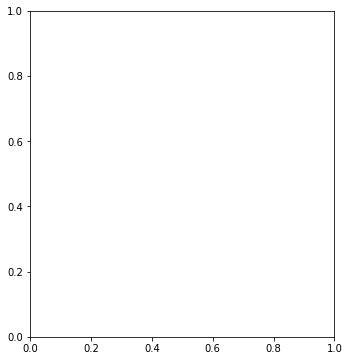

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# PCC 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_pccs, 'b', label='Train PCC')
plt.plot(epochs, val_pccs, 'r', label='Val PCC')
plt.title('Train and Validation PCC')
plt.xlabel('Epochs')
plt.ylabel('PCC')
plt.legend()

plt.tight_layout()
#plt.savefig('learning_curve_hfeat16.png')
plt.show()

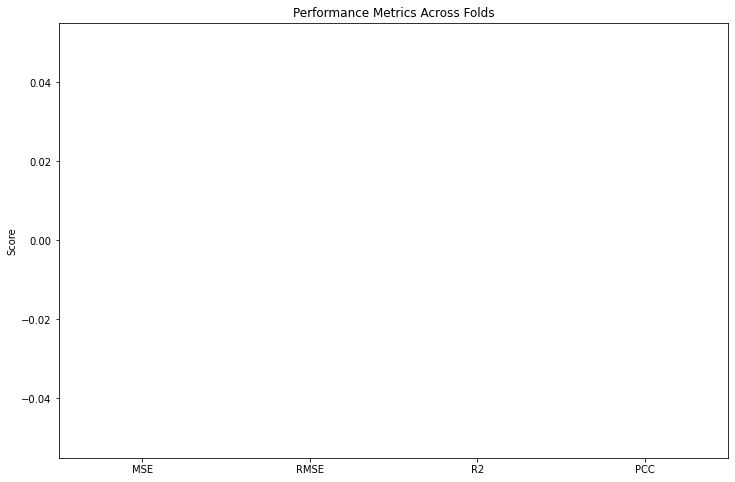

In [38]:
import matplotlib.pyplot as plt
metrics = {'MSE': all_mse, 'RMSE': all_rmse, 'R2': all_r2, 'PCC': all_pcc}
plt.figure(figsize=(12, 8))
plt.boxplot(metrics.values(), labels=metrics.keys())
plt.title('Performance Metrics Across Folds')
plt.ylabel('Score')
plt.show()

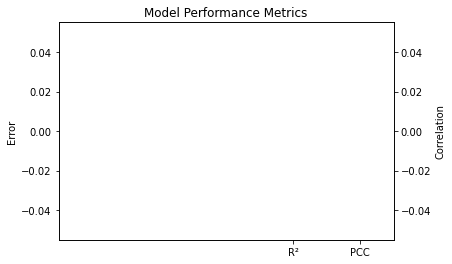

In [39]:
"""log scale"""
log_all_mse = np.log10(all_mse)
log_all_rmse = np.log10(all_rmse)
# mse, rmse -> log scale
fig, ax1 = plt.subplots()
ax1.boxplot([log_all_mse, log_all_rmse], positions=[1, 2], widths=0.6)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['log10(MSE)', 'log10(RMSE)'])
ax1.set_ylabel('Error')

# R², PCC
ax2 = ax1.twinx()
ax2.boxplot([all_r2, all_pcc], positions=[4, 5], widths=0.6)
ax2.set_xticks([4, 5])
ax2.set_xticklabels(['R²', 'PCC'])
ax2.set_ylabel('Correlation')

plt.title('Model Performance Metrics')
plt.show()

### Actual Labels, Predicted Labels 분포 그래프 (test set)

Testing: 100%|████████████████████████████████| 189/189 [00:35<00:00,  5.31it/s]


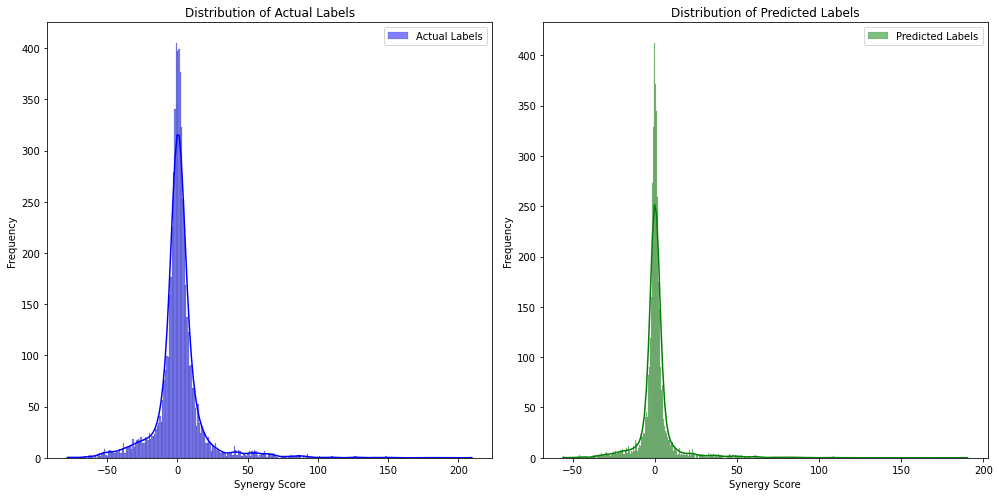

In [44]:
import seaborn as sns

model.load_state_dict(torch.load('best_model_homo_gin_fold1.pth'))
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        graphs, drug1, drug2, labels, drug1_smiles, drug2_smiles = batch
        graphs = graphs.to(device)
        drug1 = [drug_id_map[d1] for d1 in drug1]
        drug2 = [drug_id_map[d2] for d2 in drug2]
        drug1 = torch.tensor(drug1, dtype=torch.long).to(device)
        drug2 = torch.tensor(drug2, dtype=torch.long).to(device)
        labels = labels.to(device).float()

        outputs = model(graphs, drug1, drug2, drug1_smiles, drug2_smiles).squeeze()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())


plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(all_labels, kde=True, color='blue', label='Actual Labels')
plt.title('Distribution of Actual Labels')
plt.xlabel('Synergy Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(all_predictions, kde=True, color='green', label='Predicted Labels')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Synergy Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
#plt.savefig('distribution_0726_gat.png')

plt.show()


In [41]:
"""
label & pred 결과 확인
"""
for i in range(len(all_labels)):
    print(f'real: {all_labels[i]}, pred: {all_predictions[i]}')

real: -5.990493297576904, pred: -0.49758875370025635
real: 3.0824220180511475, pred: 8.816251754760742
real: 8.499147415161133, pred: 0.5147831439971924
real: 1.635080337524414, pred: -0.7923380732536316
real: 2.3615739345550537, pred: -1.7174036502838135
real: -18.692890167236328, pred: -35.96629333496094
real: -7.36515998840332, pred: -0.356056809425354
real: -7.928028583526611, pred: 0.010608106851577759
real: 19.611112594604492, pred: -1.1604030132293701
real: -12.161727905273438, pred: -11.143697738647461
real: 26.770580291748047, pred: 7.305612564086914
real: 2.554699659347534, pred: 1.8462920188903809
real: -23.172401428222656, pred: -29.459793090820312
real: -3.3394203186035156, pred: -0.1254877746105194
real: -0.20788049697875977, pred: -2.5715906620025635
real: -5.682109832763672, pred: 2.1461739540100098
real: 8.79964828491211, pred: 3.8352677822113037
real: 1.1666916608810425, pred: 1.473900318145752
real: -3.4852216243743896, pred: -5.828166961669922
real: 2.05020499229431

real: -9.502931594848633, pred: -1.4657695293426514
real: 3.263838529586792, pred: 10.710737228393555
real: -14.747421264648438, pred: -8.149178504943848
real: -3.549725294113159, pred: 0.1323247104883194
real: -3.8974149227142334, pred: -1.6139724254608154
real: -52.176204681396484, pred: -45.87869644165039
real: 9.119003295898438, pred: 0.4093194007873535
real: -0.7763164639472961, pred: 0.0563313364982605
real: -4.663254261016846, pred: 1.7784204483032227
real: 19.5803165435791, pred: 2.537498950958252
real: -0.8849732279777527, pred: 0.00971829891204834
real: 61.232696533203125, pred: 44.79008102416992
real: 0.054949212819337845, pred: -0.21810400485992432
real: -3.43453311920166, pred: -3.3187878131866455
real: -10.534286499023438, pred: 0.5543211102485657
real: -0.09183035045862198, pred: 0.31119194626808167
real: -1.2423021793365479, pred: 1.2907142639160156
real: 0.05945628508925438, pred: -0.6614226698875427
real: -8.714097023010254, pred: -0.6253024935722351
real: -6.74113798

real: -0.6458218097686768, pred: -0.44626951217651367
real: 0.9807822704315186, pred: 1.3615608215332031
real: -3.0522687435150146, pred: -1.5535273551940918
real: 7.31195592880249, pred: 1.160487174987793
real: 12.505066871643066, pred: -0.5276054739952087
real: -5.2335991859436035, pred: 0.600523829460144
real: 5.381068706512451, pred: -0.5906853079795837
real: -0.13796807825565338, pred: 0.2197514772415161
real: 18.840940475463867, pred: 19.30447006225586
real: -0.25425758957862854, pred: -1.2348964214324951
real: -3.1624536514282227, pred: 14.232830047607422
real: 0.8962180018424988, pred: -1.4022996425628662
real: 1.318687915802002, pred: 0.04244053363800049
real: -49.03377151489258, pred: -21.896406173706055
real: -21.100271224975586, pred: -7.746265411376953
real: 14.217432022094727, pred: 5.839760780334473
real: -8.080160140991211, pred: 1.2638472318649292
real: 0.950965404510498, pred: 0.850648820400238
real: 0.2378961741924286, pred: 0.5236309766769409
real: -11.1865034103393

In [42]:
# train 평균 계산
mean_mse = np.mean(all_mse)
mean_rmse = np.mean(all_rmse)
mean_r2 = np.mean(all_r2)
mean_pcc = np.mean(all_pcc)

print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R2: {mean_r2:.4f}")
print(f"Mean PCC: {mean_pcc:.4f}")

Mean MSE: nan
Mean RMSE: nan
Mean R2: nan
Mean PCC: nan


/data/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [43]:
# 5개의 모델 파일명 리스트
model_files = [
    'best_model_homo_gin_fold1.pth',
    #'best_model_homo_001_fold2.pth',
    #'best_model_homo_001_fold3.pth',
    #'best_model_2_fold4.pth',
    #'best_model_2_fold5.pth'
    
]
test_mse = []
test_rmse = []
test_r2 = []
test_pcc = []

def evaluate_model(model_file, test_loader, device, drug_id_map):
    model.load_state_dict(torch.load(model_file), strict=False)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            graphs, drug1, drug2, labels, s1, s2 = batch
            graphs = graphs.to(device)
            drug1 = [drug_id_map[d1] for d1 in drug1]
            drug2 = [drug_id_map[d2] for d2 in drug2]
            drug1 = torch.tensor(drug1, dtype=torch.long).to(device)
            drug2 = torch.tensor(drug2, dtype=torch.long).to(device)
            labels = labels.to(device).float()

            outputs = model(graphs, drug1, drug2, s1, s2).squeeze()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_predictions)
    pcc, _ = pearsonr(all_labels, all_predictions)

    return mse, rmse, r2, pcc

# 각 모델 평가
for model_file in model_files:
    mse, rmse, r2, pcc = evaluate_model(model_file, test_loader, device, drug_id_map)
    test_mse.append(mse)
    test_rmse.append(rmse)
    test_r2.append(r2)
    test_pcc.append(pcc)

# 평균 계산
mean_test_mse = np.mean(test_mse)
mean_test_rmse = np.mean(test_rmse)
mean_test_r2 = np.mean(test_r2)
mean_test_pcc = np.mean(test_pcc)

print("Evaluation Metrics:")
print(f"Mean MSE: {mean_test_mse:.4f}")
print(f"Mean RMSE: {mean_test_rmse:.4f}")
print(f"Mean R²: {mean_test_r2:.4f}")
print(f"Mean PCC: {mean_test_pcc:.4f}")


Testing: 100%|████████████████████████████████| 189/189 [00:35<00:00,  5.28it/s]

Evaluation Metrics:
Mean MSE: 129.7070
Mean RMSE: 11.3889
Mean R²: 0.6050
Mean PCC: 0.7842
